### Notebook environment for simple plots

In [5]:
import  numpy as np, scipy as sp, pandas as pd, matplotlib.pyplot as plt, os as os
import  scipy.io as spio
from    matplotlib.gridspec import GridSpec
from    pathlib import Path
import  matplotlib.gridspec as gridspec
from    matplotlib.ticker import ScalarFormatter, FuncFormatter
import  matplotlib.ticker as mticker
from    obspy import Stream,Trace
from    obspy.core import UTCDateTime, read
from    instrument_restitution import apply_geophone_tf_inv, geophone_tf, compute_ground_motion, calculate_Mlv
import  kavutil_2 as kt
from    datetime import datetime, timedelta
from    obspy.geodetics import degrees2kilometers, gps2dist_azimuth
from    kavutil_2 import get_days_list, get_data4
from    plutil import set_size
from    kav_init import *
from scipy.signal import correlate
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import spearmanr, pearsonr



In [2]:
day, t1 = pd.to_datetime('2023-04-05T00:00:00'), pd.to_datetime('2023-04-05') #pd.to_datetime('2023-04-05T8:00:00')
days3d = get_days_list(day, t1, stationdir=['KAV04','KAV11'], stationid=['c0939','c0941'])
daysbbd= get_days_list(day, t1, stationdir=['KAV00','KAV11'], stationid=['c0bdd','c0941'])
st11 = get_data4(day, stationdir='KAV11', stationid='c0941', flag_horizontal=False)
st04 = get_data4(day, stationdir='KAV04', stationid='c0939', flag_horizontal=False)
st00 = get_data4(day, stationdir='KAV00', stationid='c0bdd', flag_horizontal=False)

In [ ]:
test = Stream()
test.append(st11[0])
test.append(st04[0])
test.append(st00[0])
# test[0].stats.station, test[1].stats.station, test[2].stats.station = 'KAV11', 'KAV04', 'KAV00'
test[0].stats.network, test[1].stats.network, test[2].stats.network = 'Array 2', 'Array 1', 'Array 1'
test[0].stats.location, test[1].stats.location, test[2].stats.location = '-8.819°N 158.150°E', '-8.768°N 158.208°E', '-8.766°N 158.212°E'
# test.plot(type='relative', color='k', linewidth=0.5, grid=True, show=False)
test.detrend('demean').plot(type='relative', color='k', linewidth=0.5, grid=True, show=False)

In [3]:
time = pd.to_datetime('2023-04-05T00:00:00')+ pd.to_timedelta(st11[0].times(), unit='s')


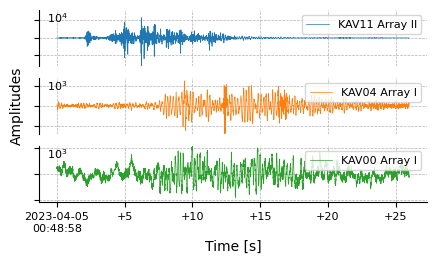

In [ ]:
wind0, wind1 = pd.to_datetime('2023-04-05T00:48:58'), pd.to_datetime('2023-04-05T00:49:24')
seq = (time >= wind0) & (time <= wind1)

fig = plt.figure(figsize=(5, 2.5))
tr11, tr04, tr00 = st11[0].copy(), st04[0].copy(), st00[0].copy()
d0, d1 = [data.detrend('demean').data[seq] for data in [tr11, tr04]]
d2 = tr00.data[seq] - np.mean(tr00.data[seq])  # KAV00 is not detrended
tplot = tr11.times()[seq] - tr11.times()[seq][0]  # relative time

gs = gridspec.GridSpec(3, 1, hspace=0.2)
ax = [fig.add_subplot(gs[i, 0], sharex=None if i == 0 else ax[0]) for i in range(3)]
[a.spines['top'].set_visible(False) for a in ax]
[a.spines['bottom'].set_visible(False) for a in [ax[0], ax[1]]]

# Plotting
ax[0].plot(tplot, d0, color='C0', lw=0.5, label='KAV11 Array II')
ax[1].plot(tplot, d1, color='C1', lw=0.5, label='KAV04 Array I')
ax[2].plot(tplot, d2, color='C2', lw=0.5, label='KAV00 Array I')

# Legends
[a.legend(loc='upper right', fontsize=fontsizelegend, frameon=True) for a in ax]

# X-axis label and formatting
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)


# Y-axis label
ax[1].set_ylabel('Amplitudes')

# Uniform Y-limits
[ax[i].set_ylim(-max(abs(d)), max(abs(d))) for i, d in enumerate([d0, d1, d2])]

# Grid and spine cleanup
[a.grid(which='both', linestyle='--', linewidth=0.5) for a in ax]
[a.spines['right'].set_visible(False) for a in ax]

# ======== Custom Tick Formatting ========
yticks,yticklabels= [[-60000, 0, 60000], [-5000, 0, 5000], [-2500, 0, 2500]],''

# Y-axis: show only scientific offset, no y-tick marks or labels
labels = ['$10^{4}$', '$10^{3}$','$10^{3}$']

for i, a in enumerate(ax):
    a.text(0.02, 0.98, labels[i], transform=a.transAxes,
           fontsize=fontsizelegend, va='top', ha='left')
    a.set_yticks(yticks[i])
    a.set_yticklabels(yticklabels, fontsize=fontsizelegend)
    
    # a.yaxis.set_major_formatter(ScalarFormatter(useOffset=True, useMathText=True))
    # a.get_yticklabels().set_visible(False)  # Hide y-tick labels



# X-axis: remove ticks and tick lines for ax[0] and ax[1]
for a in [ax[0], ax[1]]:
    a.tick_params(axis='x', which='both', bottom=False, top=False)
ax[2].set_xticks([0,5,10,15,20,25])
ax[2].set_xticklabels([wind0.strftime('%Y-%m-%d\n%H:%M:%S'), '+5', '+10', '+15', '+20', '+25'], fontsize=fontsizelegend)
ax[2].set_xlabel('Time [s]')

# plt.savefig(os.path.join(rootouts,'thesis','arrival_offset.png'), dpi=300, bbox_inches='tight')




In [4]:
def dms_to_dd(degrees: int, minutes: int, seconds: float, direction: str) -> float:
    """
    Convert coordinates from DMS (degrees, minutes, seconds) to decimal degrees.

    Parameters
    ----------
    degrees : int
        Degrees component of the coordinate.
    minutes : int
        Minutes component of the coordinate.
    seconds : float
        Seconds component of the coordinate.
    direction : str
        Cardinal direction ('N', 'S', 'E', 'W').

    Returns
    -------
    float
        Decimal degree representation.
    """
    dd = degrees + minutes / 60 + seconds / 3600
    if direction.upper() in ['S', 'W']:
        dd *= -1
    return dd

In [5]:
kav11 = [dms_to_dd(8, 49,  8., 'S'), dms_to_dd(158,  9,  1., 'E')]
kav04 = [dms_to_dd(8, 46,  3., 'S'), dms_to_dd(158, 12, 29., 'E')]
kav00 = [dms_to_dd(8, 45, 58., 'S'), dms_to_dd(158, 12, 42., 'E')]

summit2 = [dms_to_dd(8, 59, 39., 'S'), dms_to_dd(157, 58, 14., 'E')]
summit = [-8.991, 157.979]

In [6]:
dist, azf, azb = [], [], []

for i, (lat, lon) in enumerate([kav11, kav04, kav00]):
    d, az1, az2 = gps2dist_azimuth(summit2[0], summit2[1], lat, lon)
    dist.append(d / 1000)  # Convert to kilometers
    azf.append(az1)
    azb.append(az2)
dist, azf, azb = np.array(dist), np.array(azf), np.array(azb)

dist1104, azf1104, azb1104 = gps2dist_azimuth(kav11[0], kav11[1], kav04[0], kav04[1])
dist1100, azf1100, azb1100 = gps2dist_azimuth(kav11[0], kav11[1], kav00[0], kav00[1])
dist0400, azf0400, azb0400 = gps2dist_azimuth(kav04[0], kav04[1], kav00[0], kav00[1])
[dist1104, dist1100, dist0400] = [d / 1000 for d in [dist1104, dist1100, dist0400]]  # Convert to kilometers


### Load cata for full 3D empiric and plot bar

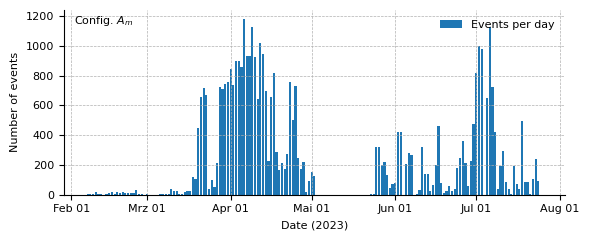

In [97]:
sec = 20.0
interval = 'D'
barcata_am = pd.read_pickle(os.path.join(rootouts,'cata_v11.3D_full_empiric',f'cata_v11.3D_full.empiric_{sec}s_slim.pkl'))
daily_am = barcata_am['Eventtime(UTC)'].dt.floor(interval).value_counts().sort_index()
df_am = pd.DataFrame({'date': daily_am.index, 'count': daily_am.values})

fig, ax = plt.subplots(figsize=(6, 2.5))
ax.bar(df_am['date'], df_am['count'], width=0.8, color='C0',linewidth=0.5, label='Events per day')
ax.set_xlabel('Date (2023)', fontsize=fontsizelegend)
ax.set_ylabel('Number of events', fontsize=fontsizelegend)
ax.legend(loc='upper right', fontsize=fontsizelegend, frameon=False)
fig.text(0.02, 0.98, 'Config. $A_{m}$', transform=ax.transAxes,
           fontsize=fontsizelegend, va='top', ha='left')
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', labelsize=fontsizelegend)
[ax.spines[spine].set_visible(False) for spine in ['top', 'right']]
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig(os.path.join(rootouts,'thesis','daily_eventcount_overview.png'), dpi=300, bbox_inches='tight')



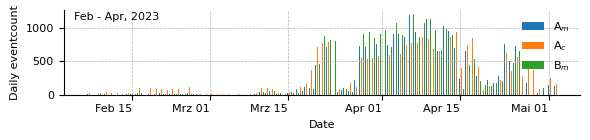

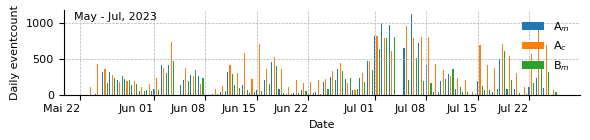

In [100]:
sec = 20.0
interval = 'D'
barcata_am = pd.read_pickle(os.path.join(rootouts,'cata_v11.3D_full_empiric',f'cata_v11.3D_full.empiric_{sec}s_slim.pkl'))
barcata_ac = pd.read_pickle(os.path.join(rootouts,'cata_v11.3D_full_compute',f'cata_v11.3D_full_compute_{sec}s_slim.pkl'))
barcata_bm = pd.read_pickle(os.path.join(rootouts,'cata_v11.bbd_full_empiric',f'cata_v11.bbd_full.empiric_{sec}s_slim.pkl'))
# daily counts
bardaily_am = barcata_am['Eventtime(UTC)'].dt.floor(interval).value_counts().sort_index()
bardaily_ac = barcata_ac['Eventtime(UTC)'].dt.floor(interval).value_counts().sort_index()
bardaily_bm = barcata_bm['Eventtime(UTC)'].dt.floor(interval).value_counts().sort_index()

df_am = pd.DataFrame({'Date': bardaily_am.index, 'Count': bardaily_am.values})
df_ac = pd.DataFrame({'Date': bardaily_ac.index, 'Count': bardaily_ac.values})
df_bm = pd.DataFrame({'Date': bardaily_bm.index, 'Count': bardaily_bm.values})

width=.15
tds = [0, 8, 16]
configlabels = ['A$_m$', 'A$_c$', 'B$_m$']
timeframe = ['Feb - Apr, 2023', 'May - Jul, 2023']

for i, (s,e) in enumerate(seasons[:2]):
    [am,ac,bm] = [d[(d['Date'] >= s) & (d['Date'] <= e)] for d in [df_am, df_ac, df_bm]]

    # Plot bar chart
    fig, ax = plt.subplots(figsize=(6, 1.5))
    [ax.bar(d['Date']+timedelta(hours=tds[j]), d['Count'], width=width, color='C{}'.format(j), linewidth=0.5, label=configlabels[j]) for j,d in enumerate([am, ac, bm])]
    # ax.bar(am['Date']+timedelta(hours=tds[i]), am['Count'], width=width, color='C0', linewidth=0.5, label=configlabels[0])
    # ax.bar(ac['Date']+timedelta(hours=tds[i]), ac['Count'], width=width, color='C1', linewidth=0.5, label=configlabels[1])
    # ax.bar(bm['Date']+timedelta(hours=tds[i]), bm['Count'], width=width, color='C2', linewidth=0.5, label=configlabels[2])
    ax.set_xlabel('Date', fontsize=fontsizelegend)
    ax.set_ylabel('Daily eventcount', fontsize=fontsizelegend)
    ax.legend(loc='upper right', fontsize=fontsizelegend, frameon=False)
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', labelsize=fontsizelegend)
    fig.text(0.02, 0.98, f'{timeframe[i]}', transform=ax.transAxes,
                fontsize=fontsizelegend, va='top', ha='left')
    [ax.spines[spine].set_visible(False) for spine in ['top', 'right']]
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    fig.autofmt_xdate(ha='right', rotation=0)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.tight_layout()
    plt.savefig(os.path.join(rootouts,'thesis',f'daily_eventcount_overview_ep{i+1}.png'), dpi=300, bbox_inches='tight')
    


### Functions

In [ ]:

def select_events_v2(df:             pd.DataFrame,
                     datetime_start: pd.Timestamp | str,
                     datetime_end:   pd.Timestamp | str,
                     asstring=False):
    '''
    Select events from catalog, in between on start-/end date.

    Parameters:
    -----------
    df: pd.DataFrame
        DataFrame containing the catalog.
    datetime_start: datetime64 | str
        Start date of interest.
    datetime_end: datetime64 | str
        End date of interest.
    asstring: bool, optional
        If True, read in datetime_start/_end as str.

    Returns:
    --------
    selected_events: pd.DataFrame
        DataFrame containing the selected events.

    @ LB 2024/08/09
    '''
    if asstring:
        datetime_start = pd.to_datetime(datetime_start)
        datetime_end   = pd.to_datetime(datetime_end)
    # Check wether either the key 'puretime' or 'date' is present in the DataFrame
    if 'puretime' in df.columns:
        tvar = 'puretime'
    elif 'date' in df.columns:
        tvar = 'date'
    elif 'Eventtime(UTC)' in df.columns:
        tvar = 'Eventtime(UTC)'
    else:
        raise ValueError('No datetime column found in DataFrame. Please provide a DataFrame with a "puretime", "date" or "Eventtime(UTC)" column.')

    print(f"Column '{tvar}' found in dataframe.")
    selected_events = df[(df[tvar] >= datetime_start) & (df[tvar] <= datetime_end)]

    # if 'puretime' in df.columns:
    #     selected_events = df[(df['puretime'] >= datetime_start) & (df['puretime'] <= datetime_end)]
    #     print(' "puretime" column found in DataFrame.')
    # elif 'date' in df.columns:
    #     selected_events = df[(df['date']     >= datetime_start) & (df['date']     <= datetime_end)]
    #     print('Found "date" column in DataFrame containing datetimes.')
    # else:
    #     print('No datetime column found in DataFrame.')
    #     return None
    if selected_events.empty:
        raise ValueError(f'No events found between {datetime_start} and {datetime_end}. Please check the catalog.')
    else:
        print(f'Selected {len(selected_events)} events between {datetime_start} and {datetime_end}.')
        return selected_events

def retrieve_trace_data(selected_events, stationdir, stationid):
    """
    Retrieve seismic trace data corresponding to the events provided.
    Based on a numpy datetime timestamp, stationname and id.

    Parameters
    ----------
    selected_events : pd.DataFrame
        DataFrame containing the selected events.
    stationdir : str
        Subdirectory to access the data.
    stationid : str
        Station ID to access the data.

    Returns
    -------
    Stream
        Stream object containing the retrieved trace data.
    """
    from obspy import UTCDateTime, Stream, Trace, read
    from kav_init import rootdata
    # Determine which column to use for event time
    if 'puretime' in selected_events.columns:
        tvar = 'puretime'
    elif 'date' in selected_events.columns:
        tvar = 'date'
    elif 'Eventtime(UTC)' in selected_events.columns:
        tvar = 'Eventtime(UTC)'
    else:
        raise ValueError("No valid time column found in the selected events DataFrame.")

    stream = Stream()

    for index, event in selected_events.iterrows():
        event_time = event[tvar]
        
        start_time  = UTCDateTime(event_time - timedelta(seconds=10))  # 10 seconds before the event
        end_time    = UTCDateTime(event_time + timedelta(seconds=30))  # 30 seconds after the event

        # Read and append data files to the stream
        if start_time.day != end_time.day:
            filename1   = f"{rootdata}/{stationdir}/{stationid}{start_time.strftime('%y%m%d')}000000.pri0"
            filename2   = f"{rootdata}/{stationdir}/{stationid}{end_time.strftime('%y%m%d')}000000.pri0"
            tr1, tr2    = read(filename1)[0], read(filename2)[0]
            trace       = tr1.__add__(tr2)
            trace       = trace.slice(start_time, end_time, nearest_sample=True)
            stream.append(trace)
        else:
            filename    = f"{rootdata}/{stationdir}/{stationid}{event_time.strftime('%y%m%d')}000000.pri0"
            trace       = read(filename, starttime=start_time, endtime=end_time)[0]
            stream.append(trace)
    return stream 

def calculate_Mlv(trace:        Trace,
                  distance:     float,
                  flag_obspy:   bool = False,
                  ex_WA_waveform: bool = False) -> float:
    """
    Calculate the vertical local magnitude (MLv) from a Trace object containing seismic event data.

    Parameters
    ----------
    trace : Trace
        Trace object containing the seismic event data.
    distance : float
        Distance from the event to the seismograph station.
    flag_obspy : bool, optional
        Flag to use ObsPy's simulate_seismometer function, by default False.

    Returns
    -------
    float
        Vertical local magnitude (MLv) of the event.
    """
    from obspy.signal.invsim import simulate_seismometer
    import math
    tr                      = trace.copy()
    tr.detrend('demean'); tr.taper(max_percentage=0.05, type='hann'); tr.detrend('demean')

    p0, p1, z0, z1  = -5.49779 - 5.60886j, -5.49779 + 5.60886j, 0.0, 0.0

    

    # --- Wood-Anderson simulation via ObsPy ---
    if flag_obspy:
        signal_modified   = simulate_seismometer(
            tr.data.copy(),
            samp_rate               = tr.stats.sampling_rate,
            paz_remove              = None,
            # paz_simulate          = {'poles': [-6.2832 - 0.9425j, -6.2832 + 0.9425j], 'zeros': [0j], 'gain': 2080.0},
            paz_simulate            = {'poles': [-5.49779 - 5.60886j, -5.49779 + 5.60886j],
                                       'zeros': [0.+0j, 0j], 'gain': 1.0},
            remove_sensitivity      = False,
            simulate_sensitivity    = False,
            # water_level           = 60.0,
            zero_mean               = False,
            taper                   = False,
            nfft_pow2               = True)
    else:
        signal                      = tr.data.copy()
        signal_fft                  = np.fft.fft(signal)
        tf_woodanderson             = np.zeros_like(signal_fft, dtype=complex)
        n                           = len(signal)
        idx                         = np.array(range(n//2+1))
        f                           = idx / (n * tr.stats.delta)
        omega                       = 2 * np.pi * f
        s                           = 1j * omega
        H                           = (s - z0) * (s - z1) / ((s - p0) * (s - p1))
        tf_woodanderson[idx]        = H
        signal_fft[idx]             = signal_fft[idx] * tf_woodanderson[idx]
        idx                         = np.array(range(1, n//2))
        signal_fft[n-idx]           = np.conj(signal_fft[idx])
        signal_modified             = np.fft.ifft(signal_fft)

    trace_WA                        = Trace(data=signal_modified)
    trace_WA.stats.sampling_rate    = tr.stats.sampling_rate
    trace_WA.stats.starttime        = tr.stats.starttime
    trace_WA.filter('highpass', freq=0.5, zerophase=True)
    trace_WA.detrend('demean')

    # Calculate peak-through amplitude
    amplitude                       = max(abs(trace_WA.data))
    amplitude_nano                  = amplitude * 10**9

    # Calculate vertical local magnitude (MLv)
    # mlv = math.log10(amplitude*10**9) + 1.11 * math.log10(distance) + 0.00189 * distance - 2.09
    mlv = math.log10(amplitude_nano) + 1.11 * math.log10(distance) + 0.0018 * distance - 2.09
    if ex_WA_waveform is True:
        return mlv, trace_WA
    else:
        return mlv

def apply_geophone_tf_inv_v2(
        trace:              Trace,
        transfer_function:  np.ndarray = None,
        eps:                float = 1e-06 
        ):
    
    """
    This function removes the instrument response from a trace object in unit [counts].
    By applying the inverse transfer function, the trace is converted to the physical unit [m/s].
    Ground velocity is obtained.

    Parameters
    ----------
    trace : Trace
        Trace object containing the data to be filtered.
    transfer_function : np.ndarray, optional
        Transfer function of the geophone, by default None.
    eps : float, optional
        Small value to prevent division by zero, by default 1.e9.
    
    Returns
    -------
    Trace
        Trace object containing the filtered signal.
    """
    tr          = trace.copy()                                  # copy trace object
    tr.detrend('demean')                                        # 1st demean   
    tr.taper(max_percentage=0.1, type='hann')                   # taper
    tr.detrend('demean')                                        # 2nd demean
    signal      = tr.data.copy()                                # copy signal data

    if transfer_function is None:                               # compute transfer function if not provided
        Gs:     float       = 27.7, # Geophone sensitivity in V/m/s
        Cv:     float       = 6.5574e7, # Digital compliance in counts/V
        k:      float       = 1.0,
        p1, p2, z1, z2      = -19.78 + 20.20j, -19.78 - 20.20j, 0.0, 0.0

        trace4tf            = trace.copy()
        trace4tf.detrend('demean')
        trace4tf.taper(max_percentage=0.1, type='hann') 
        signal4tf           = trace4tf.data.copy()

        signal_fft_4tf      = np.fft.fft(signal4tf)             # fft of tapered signal
        n4tf                = len(signal4tf)                    # length of signal
        dt                  = 1/trace.stats.sampling_rate       # sampling interval
        tf                  = np.ones_like(signal_fft_4tf)      # initialise tf array

        # broadcast over positive frequencies to generate frequencies & calculate the transfer function
        idx                 = np.array(range(n4tf//2+1))
        tf_slice            = tf[idx]                           # include Nyquist frequency for even n
        f                   = idx / (n4tf*dt)                   # compute frequency at index i
        omega               = 2*np.pi*f                         # compute angular frequency
        s                   = 1j*omega                          # compute complex frequency
        H                   = k * s**2 / ((s - p1) * (s - p2))  # compute transfer function
        tf_slice            = H * Gs * Cv                       # consider sensitivities to retrieve output in counts
        tf[idx]             = tf_slice                          # fill in tf array

        transfer_function   = tf

    # breakpoint()
    tf                              = transfer_function.copy()              # rename variable
    npts                            = len(signal)                           # length of signal
    idx                             = np.array(range(npts//2+1))            # indexing positive frequencies

    signal_fft                      = np.fft.rfft(signal)                    # fft of tapered signal
    inv_tf                          = np.zeros_like(tf)                     # initialise inv tf
    inv_tf[idx]                     = 1. / (tf[idx]+ eps*np.max(np.abs(tf)))# compute inv tf

    signal_fft_restored             = signal_fft.copy()                     # initialise restored signal
    signal_fft_restored[idx]        = signal_fft[idx] * inv_tf[idx]         # apply inverse transfer function to positive frequencies
    del idx                                                                 # clear variable
    idx                             = np.array(range(1,npts//2 +1))         # starts from 2 to exclude DC; handles both even and odd n
    signal_fft_restored[npts-idx]   = np.conj(signal_fft_restored[idx])     # reconstruct full spectrum by filling in the negative frequencies using conjugate symmetry

    signal_restored                 = np.fft.irfft(signal_fft_restored)      # inverse fft to get the filtered signal

    tr_restored                     = Trace(data=signal_restored)
    tr_restored.stats.sampling_rate, tr_restored.stats.starttime = tr.stats.sampling_rate, tr.stats.starttime
    tr_restored.filter('highpass', freq=0.5, zerophase=True)

    return tr_restored


### test magnitudes

In [8]:
start = pd.to_datetime('2023-04-05T00:45:00')
end = pd.to_datetime('2023-04-05T00:49:00')

In [67]:
cata = pd.read_pickle("D:/data_kavachi_both/results/cata_v11.3D_full_empiric/cata_v11.3D_full.empiric_20.0s_slim.pkl")
selected_events = select_events_v2(cata, start, end, asstring=False)
length_flag = True

Column 'Eventtime(UTC)' found in dataframe.
Selected 3 events between 2023-04-05 00:45:00 and 2023-04-05 00:49:00.


In [ ]:
straw = retrieve_trace_data(selected_events, stationdir='KAV11', stationid='c0941')
stvel, stdis, stwas = Stream(), Stream(), Stream()
mlvlist = []

for i, trace in enumerate(straw):
    trvel       = apply_geophone_tf_inv(trace)
    # trvel2      = apply_geophone_tf_inv_v2(trace)
    trdis       = compute_ground_motion(trvel.copy())
    mlv, trwas  = calculate_Mlv(trdis.copy(),distance=dist[i], ex_WA_waveform=True)

    stvel.append(trvel)
    stdis.append(trdis)
    stwas.append(trwas)

    mlvlist.append(mlv)
mlvlist = np.array(mlvlist)




c:\Users\Ludwig\anaconda3\envs\seismics\Lib\site-packages\numpy\core\_asarray.py:106: ComplexWarning: Casting complex values to real discards the imaginary part
  return asanyarray(a, dtype=dtype)


In [94]:
paz45 = {'poles':       [-1.58336E+01 -2.34251E+01j, -1.58336E+01  +2.34251E+01j],
         'zeros':       [+0.00000E+00  +0.00000E+00, +0.00000E+00  +0.00000E+00],
         'gain':        +1.0,
         'sensitivity':  2.88000E+01}


pazbbd= { 'poles':      [-3.69100E-02  -3.70200E-02j, -3.69100E-02  +3.70200E-02j,
                         -3.43000E+02  +0.00000E+00j, -3.70000E+02  -4.67000E+02j,
                         -3.70000E+02  +4.67000E+02j, -8.36000E+02  -1.52200E+03j,
                         -8.36000E+02  +1.52200E+03j, -4.90000E+03  -4.70000E+03j,
                         -4.90000E+03  +4.70000E+03j, -6.90000E+03  +0.00000E+00j,
                         -1.50000E+04  +0.00000E+00j ],
          'zeros':      [+0.00000E+00  +0.00000E+00j, +0.00000E+00  +0.00000E+00j,
                         -3.92000E+02  +0.00000E+00j, -1.49000E+03  +1.74000E+03j,
                         -1.49000E+03  -1.74000E+03j, -1.96000E+03  +0.00000E+00j],
          'gain':        +4.34493E+17,
          'sensitivity':  7.54300E+02}

pazWA = {'poles':       [-5.49779E+00  -5.60886E+00j, -5.49779E+00  +5.60886E+00j],
         'zeros':       [+0.00000E+00  +0.00000E+00j, +0.00000E+00  +0.00000E+00j],
         'gain':        2080.0}

def compute_transfer_function(pazdict, gain=1.0, npts=4096, dt=0.01):
    """
    Compute the transfer function H(f) for a given set of poles, zeros, and gain.

    Parameters
    ----------
    poles : list of complex
        Poles of the system.
    zeros : list of complex
        Zeros of the system.
    gain : float, optional
        System gain (default is 1.0).
    npts : int, optional
        Number of frequency points (default is 4096).
    dt : float, optional
        Sampling interval in seconds (default is 0.01).

    Returns
    -------
    f : np.ndarray
        Frequency array (Hz).
    H : np.ndarray
        Transfer function (complex values).
    """
    f = np.fft.rfftfreq(npts, dt)
    s = 2j * np.pi * f
    numerator = np.ones_like(s, dtype=complex)
    denominator = np.ones_like(s, dtype=complex)

    zeros = pazdict['zeros']
    poles = pazdict['poles']
    gain  = 1.
    if 'gain' in pazdict:
        gain *= pazdict['gain']
    if 'sensitivity' in pazdict:
        gain *= pazdict['sensitivity']

    for z in pazdict['zeros']:
        numerator *= (s - z)
    for p in pazdict['poles']:
        denominator *= (s - p)
    H = gain * numerator / denominator
    return f, H

# short period seismometer transfer function
f_sp, H_sp = compute_transfer_function(paz45, gain=1.0, npts=4096, dt=0.01)
# broadband seismometer transfer function
f_bbd, H_bbd = compute_transfer_function(pazbbd, gain=1.0, npts=4096, dt=0.01)
# Wood-Anderson transfer function
f_wa, H_wa = compute_transfer_function(pazWA, gain=1.0, npts=4096, dt=0.01)

H_sp_dbnorm, H_bbd_dbnorm, H_wa_dbnorm = [20 * np.log10(np.maximum(np.abs(H), 1e-20)) for H in [H_sp, H_bbd, H_wa]]
H_sp_dbnorm, H_bbd_dbnorm, H_wa_dbnorm = [H - np.max(H) for H in [H_sp_dbnorm, H_bbd_dbnorm, H_wa_dbnorm]]  # normalize to 0 dB

# H_dB = 20 * np.log10(np.maximum(np.abs(H), 1e-20))  # avoid log(0)
# H_dB -= np.max(H_dB)  # normalize to 0 dB



In [102]:
t = straw[0].times()  # time vector for plotting
print(straw[0].stats.starttime, straw[0].stats.endtime)

2023-04-05T00:45:17.140000Z 2023-04-05T00:45:57.140000Z


### Transfer functions

c:\Users\Ludwig\anaconda3\envs\seismics\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Ludwig\anaconda3\envs\seismics\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Ludwig\AppData\Local\Temp\ipykernel_6960\378562199.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


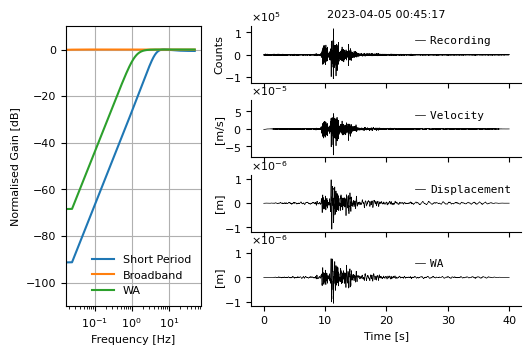

In [ ]:
# Plotting
ievent = 0

import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
from plutil import set_size
# fig = plt.figure(figsize=(12, 6))
fig = plt.figure(figsize=set_size(textwidth, fraction=1.2))
gs = gridspec.GridSpec(4, 2, width_ratios=[1, 2], height_ratios=[1, 1, 1, 1], wspace=0.25, hspace=0.3)

# Left plot: Transfer functions
ax0 = fig.add_subplot(gs[:, 0])
ax0.semilogx(f_sp, H_sp_dbnorm, label="Short Period")
ax0.semilogx(f_bbd, H_bbd_dbnorm, label="Broadband")
ax0.semilogx(f_wa, H_wa_dbnorm, label="WA")
# ax0.set_title("Instrument Transfer Functions")
ax0.set_xlabel("Frequency [Hz]",fontsize=fontsizelegend)
ax0.set_ylabel("Normalised Gain [dB]", fontsize=fontsizelegend)
ax0.set_ylim(-110, 10)  # Set y-limits for better visibility
ax0.legend(fontsize=fontsizelegend, frameon=False,loc='best')
ax0.grid(True)
ax0.tick_params(axis='both', which='major', labelsize=fontsizelegend)

# Right column: Time-domain traces
countstrace = straw[ievent].copy()
titles = ["Counts", "[m/s]", "[m]", "[m]"]
labels = ["Recording", "Velocity", "Displacement", "WA"]
data = [countstrace.detrend('demean').data, stvel[ievent].data, stdis[ievent].data, stwas[ievent].data]
# time = straw[ievent].times() - straw[ievent].stats.starttime  # relative time in seconds
time = straw[ievent].times() # relative time in seconds

for i in range(4):
    ax = fig.add_subplot(gs[i, 1])
    ax.set_title(straw[ievent].stats.starttime.strftime("%Y-%m-%d %H:%M:%S"), fontsize=fontsizelegend) if i == 0 else None
    ax.plot(time, data[i], color='black', linewidth=0.5, label=labels[i].ljust(12))
    ax.set_ylabel(titles[i], fontsize=fontsizelegend)
    ax.tick_params(axis='both', labelsize=8)
    ax.set_ylim(-1.1 * np.max(np.abs(data[i])), 1.1 * np.max(np.abs(data[i])))

    # Enable scientific notation for y-axis
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))  # enforce sci notation for all ranges
    ax.yaxis.offsetText.set_fontsize(8)  # adjust font size of the 10^n label

    ax.spines['right'].set_visible(False)

    if i < 3:
        ax.tick_params(labelbottom=False)
    else:
        ax.set_xlabel("Time [s]", fontsize=fontsizelegend)
    ax.yaxis.set_label_coords(-0.10, 0.5)
    # Legend in upper left, with monospace font and aligned labels
    ax.legend(loc='upper right',
              frameon=False,
              handlelength=0.9,
              handletextpad=0.5,
              prop={'family': 'monospace', 'size': fontsizelegend})

    ax.spines['top'].set_visible(False)
plt.tight_layout()
# plt.savefig(os.path.join(rootouts, 'thesis', 'transfer_functions_and_simulations.png'), dpi=300, bbox_inches='tight')
plt.show()

### Plot time shift analysis

In [5]:
# read in catalogs and safe as dictionary
shifttimes = [2.13, 2.27, 2.43, 2.62, 2.83, 3.09, 3.4, 3.6, 3.78, 4.25]
catalog_dict = {}
for tshift in shifttimes:
    catalog_dict[tshift] = pd.read_pickle(os.path.join(rootouts, 'cata_v11.testshift', f'cata_v11.testshift_3D_empiric_tb_5.0s_shift_{tshift}s_slim.pkl'))

In [180]:
event_counts = {label: len(df) for label, df in catalog_dict.items()}
event_counts



{2.13: 3648,
 2.27: 3648,
 2.43: 3648,
 2.62: 3648,
 2.83: 3648,
 3.09: 3648,
 3.4: 3648,
 3.6: 3648,
 3.78: 3648,
 4.25: 3648}

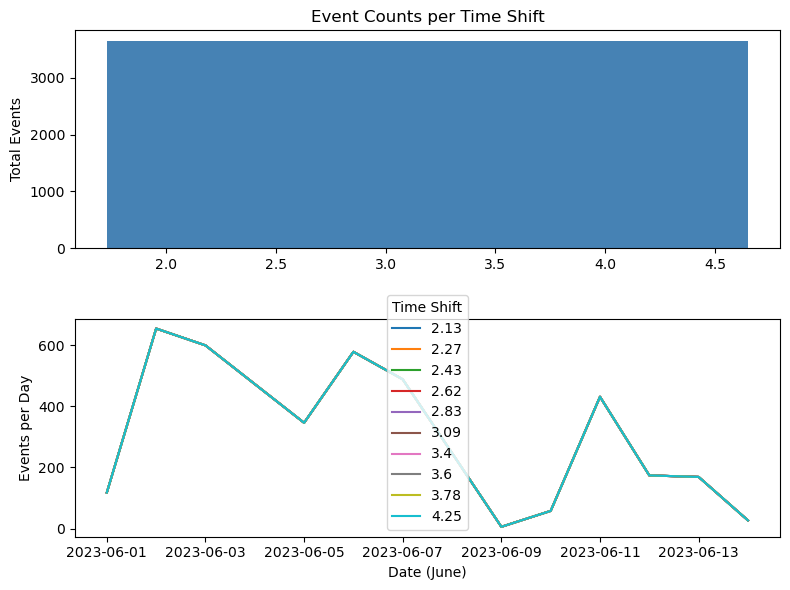

In [179]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=False)

# Top: Bar chart of total event count
axs[0].bar(event_counts.keys(), event_counts.values(), color='steelblue')
axs[0].set_ylabel("Total Events")
axs[0].set_title("Event Counts per Time Shift")

# Bottom: Daily histogram
for label, df in catalog_dict.items():
    df_daily = df['Eventtime(UTC)'].dt.floor("1D").value_counts().sort_index()
    axs[1].plot(df_daily.index, df_daily.values, label=f"{label}")

axs[1].set_ylabel("Events per Day")
axs[1].set_xlabel("Date (June)")
axs[1].legend(title="Time Shift")

plt.tight_layout()
plt.show()


### Plot comparison between different resting times


#### Read and organise data

In [42]:
# --- Configuration ---
directory           = Path("D:/data_kavachi_both/results/cata_v11.3D_empiric_june")
resting_times       = [1., 5., 10., 20., 30., 40., 50., 60., 120.]
ref_catalog_path    = Path("D:/data_kavachi_both/results/catalog_pl.txt")

# --- Load catalogs ---
catalogs            = {}
for trest in resting_times:
    path            = directory / f"cata_v11.3D_empiric_{trest:.1f}s_slim.pkl"
    # print(path)
    df              = pd.read_pickle(path)
    catalogs[trest] = pd.to_datetime(df['Eventtime(UTC)'])
# Load reference
ref_catalog         = pd.read_csv(ref_catalog_path, sep='\t', parse_dates=['Starttime','Endtime'])
ref_catalog         = ref_catalog[(ref_catalog['BAZ'] >= kav_angle[0]) & (ref_catalog['BAZ'] <= kav_angle[1])]
ref_times           = pd.to_datetime(ref_catalog['Starttime'])

# --- Define time range and daily bins ---
time_range          = pd.date_range("2023-06-01", "2023-06-30", freq='D')
days                = time_range.date

#### Plot

NameError: name 'catalogs' is not defined

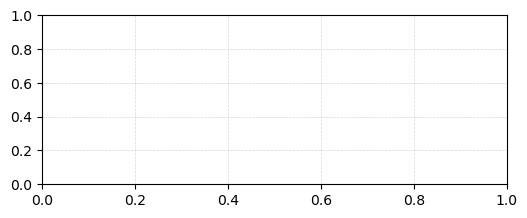

In [9]:
# --- Prepare plotting ---
colors = ['C1','C2','C3','C4','C5','C6','C7','C8','C9']
fig = plt.figure(figsize=(6, 4.5))
gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)

# --- Plot 1: Daily Counts ---
ax1 = fig.add_subplot(gs[0])
ax1.grid(which='both', linestyle='--', linewidth=0.5, alpha=.5)
for i, (trest, times) in enumerate(catalogs.items()):
    daily_counts = pd.Series(times).dt.date.value_counts().reindex(days, fill_value=0)
    ax1.plot(days, daily_counts.values, label=f"{trest:.0f} s", color=colors[i], linewidth=1)
ax1.plot(days, pd.Series(ref_times).dt.date.value_counts().reindex(days, fill_value=0).values,
         color='k', linestyle='--', label='Ref.', linewidth=1)
ax1.set_ylabel("Events/day")
ax1.tick_params(axis='x', labelbottom=False, labeltop=False)

# --- Plot 2: Cumulative Counts ---
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.grid(which='both', linestyle='--', linewidth=0.5, alpha=.5)
for i, (trest, times) in enumerate(catalogs.items()):
    cum_counts = pd.Series(times).dt.date.value_counts().reindex(days, fill_value=0).cumsum()
    ax2.plot(days, cum_counts.values, label=f"{trest:.0f} s", linewidth=1, color=colors[i])
ax2.plot(days, pd.Series(ref_times).dt.date.value_counts().reindex(days, fill_value=0).cumsum().values,
         color='k', linestyle='--', label='Ref.', linewidth=1)
ax2.set_ylabel("Cumulative")
ax2.set_xticks(days[::5])
ax2.set_xticklabels([d.strftime("%b %d") for d in days[::5]], rotation=45)


[a.yaxis.set_ticks_position('both') for a in [ax1, ax2]]
[a.tick_params(axis='y', which='both', right=True, labelright=True) for a in [ax1, ax2]]

ax2.legend(fontsize=fontsizelegend, loc='upper left', ncol=2, frameon=False)
fig.align_ylabels([ax1, ax2])
plt.tight_layout()
plt.savefig(os.path.join(rootouts, 'thesis', 'event_counts_daily_cumulative_june.png'), dpi=300, bbox_inches='tight')
plt.show()

#### Repeat for whole year, split in 3 measuring season. other plots

In [44]:
# --- Configuration ---
directory           = Path("D:/data_kavachi_both/results/cata_v11.3D_full_empiric")
resting_times       = [1., 5., 10., 20., 30., 40., 50., 60., 120.]
ref_catalog_path    = Path("D:/data_kavachi_both/results/catalog_pl.txt")

# --- Load catalogs ---
catalogs            = {}
for trest in resting_times:
    path            = directory / f"cata_v11.3D_full.empiric_{trest:.1f}s_slim.pkl"
    # print(path)
    df              = pd.read_pickle(path)
    catalogs[trest] = pd.to_datetime(df['Eventtime(UTC)'])
# Load reference
ref_catalog         = pd.read_csv(ref_catalog_path, sep='\t', parse_dates=['Starttime','Endtime'])
ref_catalog         = ref_catalog[(ref_catalog['BAZ'] >= kav_angle[0]) & (ref_catalog['BAZ'] <= kav_angle[1])]
ref_times           = pd.to_datetime(ref_catalog['Starttime'])



In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
counts_20 = catalogs[20.0].groupby(catalogs[20.0].dt.date).count().sort_index()
counts_5 = catalogs[5.0].groupby(catalogs[5.0].dt.date).count().sort_index()
counts_60 = catalogs[60.0].groupby(catalogs[60.0].dt.date).count().sort_index()
counts_gap = ref_times.groupby(ref_times.dt.date).count().sort_index()

# ax.bar(counts_gap.index, counts_gap.values, width=0.4, label='Reference', align='edge', alpha=0.7, color='gray')
ax.bar(counts_60.index, counts_60.values, width=0.4, label='60.0 s', align='edge', alpha=0.7)
ax.bar(counts_20.index, counts_20.values, width=0.4, label='20.0 s', align='center', alpha=0.7)
ax.bar(counts_5.index, counts_5.values, width=0.4, label='5.0 s', align='edge', alpha=0.7)

ax.set_title('Number of events per day')
ax.set_xlabel('Date')
ax.set_ylabel('Event count')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Ludwig\AppData\Local\Temp\ipykernel_11500\2430358721.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


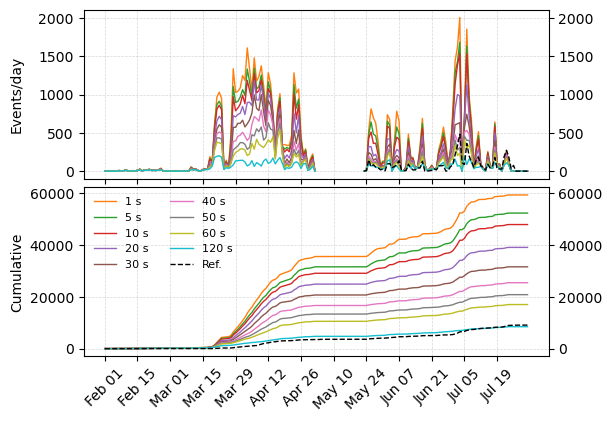

In [46]:
# --- Prepare plotting ---
fig = plt.figure(figsize=(6, 4.5))
gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
colors = ['C1','C2','C3','C4','C5','C6','C7','C8','C9']
ax1 = fig.add_subplot(gs[0])
ax1.grid(which='both', linestyle='--', linewidth=0.5,alpha=.5)

    
# --- Plot 1: Daily Counts: seasonwise ---


for i, (trest, times) in enumerate(catalogs.items()):
    for j, ep in enumerate(seasons[:2]):
        ep = pd.to_datetime(ep) 
        # --- Define time range and daily bins ---
        time_range          = pd.date_range(ep[0], ep[1], freq='D')
        days                = time_range.date

        # Filter times for the current season
        season_times = times[(times >= ep[0]) & (times <= ep[1])]
        # Count events per day in the current season
        daily_counts = pd.Series(season_times).dt.date.value_counts().reindex(days, fill_value=0)
        ax1.plot(days, daily_counts.values, label=f"{trest:.0f} s", color=colors[i], linewidth=1)

ax1.plot(days, pd.Series(ref_times).dt.date.value_counts().reindex(days, fill_value=0).values,
        color='k', linestyle='--', label='Reference', linewidth=1)
ax1.set_ylabel("Events/day")
ax1.tick_params(axis='x', labelbottom=False, labeltop=False)

# # Add legend

# --- Define time range and daily bins ---
time_range          = pd.date_range(seasons[0][0], seasons[1][1], freq='D')
days                = time_range.date

# --- Plot 2: Cumulative Counts ---
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.grid(which='both', linestyle='--', linewidth=0.5, alpha=.5)
for i, (trest, times) in enumerate(catalogs.items()):
    cum_counts = pd.Series(times).dt.date.value_counts().reindex(days, fill_value=0).cumsum()
    ax2.plot(days, cum_counts.values, label=f"{trest:.0f} s", color=colors[i], linewidth=1)
ax2.plot(days, pd.Series(ref_times).dt.date.value_counts().reindex(days, fill_value=0).cumsum().values,
        color='k', linestyle='--', label='Ref.', linewidth=1)
ax2.set_ylabel("Cumulative")
ax2.set_xticks(days[::14])
ax2.set_xticklabels([d.strftime("%b %d") for d in days[::14]], rotation=45)

[a.yaxis.set_ticks_position('both') for a in [ax1, ax2]]
[a.tick_params(axis='y', which='both', right=True, labelright=True) for a in [ax1, ax2]]

ax2.legend(fontsize=fontsizelegend, loc='upper left', ncol=2, frameon=False)
fig.align_ylabels([ax1, ax2])
plt.tight_layout()
plt.savefig(os.path.join(rootouts, 'thesis', 'cumulative_counts_seasonwise.png'), dpi=300, bbox_inches='tight')
plt.show()


C:\Users\Ludwig\AppData\Local\Temp\ipykernel_11500\2854030790.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


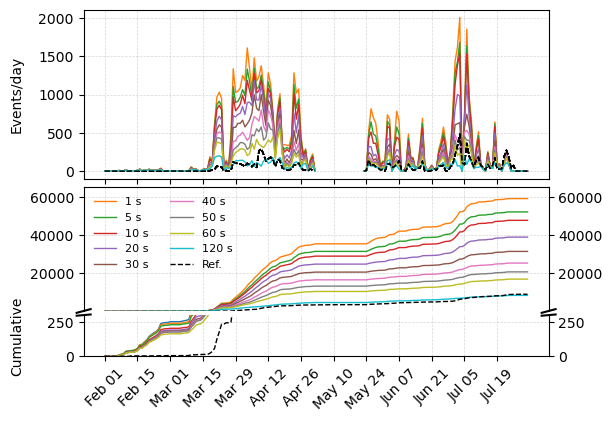

In [47]:
# --- Prepare plotting ---
fig = plt.figure(figsize=(6, 4.5))
gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
colors = ['C1','C2','C3','C4','C5','C6','C7','C8','C9']
ax1 = fig.add_subplot(gs[0])
ax1.grid(which='both', linestyle='--', linewidth=0.5,alpha=.5)

    
# --- Plot 1: Daily Counts: seasonwise ---


for i, (trest, times) in enumerate(catalogs.items()):
    for j, ep in enumerate(seasons[:2]):
        ep = pd.to_datetime(ep) 
        # --- Define time range and daily bins ---
        time_range          = pd.date_range(ep[0], ep[1], freq='D')
        days                = time_range.date

        # Filter times for the current season
        season_times = times[(times >= ep[0]) & (times <= ep[1])]
        # Count events per day in the current season
        daily_counts = pd.Series(season_times).dt.date.value_counts().reindex(days, fill_value=0)
        ax1.plot(days, daily_counts.values, label=f"{trest:.0f} s", color=colors[i], linewidth=1)
        ax1.plot(days, pd.Series(ref_times).dt.date.value_counts().reindex(days, fill_value=0).values,
            color='k', linestyle='--', label='Reference', linewidth=1)


ax1.set_ylabel("Events/day")
ax1.tick_params(axis='x', labelbottom=False, labeltop=False)

# --- Define time range and daily bins ---
time_range          = pd.date_range(seasons[0][0], seasons[1][1], freq='D')
days                = time_range.date

# Split the bottom row into two: high on top, low on bottom
gs_bottom = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], height_ratios=[3, 1], hspace=0.05)

# ↓↓↓ LOWER axis (0–10k) now placed at the BOTTOM ↓↓↓
ax2_low = fig.add_subplot(gs_bottom[1], sharex=ax1)
ax2_high = fig.add_subplot(gs_bottom[0], sharex=ax1)
[ax.grid(which='both', linestyle='--', linewidth=0.5,alpha=.5) for ax in [ax2_low, ax2_high]]

# Plot each
for i, (trest, times) in enumerate(catalogs.items()):
    cum_counts = pd.Series(times).dt.date.value_counts().reindex(days, fill_value=0).cumsum().values
    ax2_low.plot(days, cum_counts, linewidth=1)
    ax2_high.plot(days, cum_counts, color=colors[i], label=f"{trest:.0f} s", linewidth=1)

# Reference line
ref_cum = pd.Series(ref_times).dt.date.value_counts().reindex(days, fill_value=0).cumsum().values
ax2_low.plot(days, ref_cum, color='k', linestyle='--', linewidth=1)
ax2_high.plot(days, ref_cum, color='k', linestyle='--', linewidth=1, label='Ref.')

# Set limits
scaling_adaptive = 300
ax2_low.set_ylim(0, scaling_adaptive)
ax2_high.set_ylim(scaling_adaptive+1, max(ref_cum.max(), *[
    pd.Series(t).dt.date.value_counts().reindex(days, fill_value=0).cumsum().max()
    for t in catalogs.values()])*1.1)

# Hide spines and add break indicators
ax2_low.spines['top'].set_visible(False)
ax2_high.spines['bottom'].set_visible(False)

ax2_high.tick_params(labelbottom=False, bottom=False)
ax2_low.tick_params(top=False)

# Diagonal breaks (now reversed)
d = .015
kwargs_low = dict(transform=ax2_low.transAxes, color='k', clip_on=False)
ax2_low.plot((-d, +d), (1 - d, 1 + d), **kwargs_low)
ax2_low.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs_low)

kwargs_high = dict(transform=ax2_high.transAxes, color='k', clip_on=False)
ax2_high.plot((-d, +d), (-d, +d), **kwargs_high)
ax2_high.plot((1 - d, 1 + d), (-d, +d), **kwargs_high)

# Labels and formatting
ax2_low.set_ylabel("Cumulative")
ax2_low.set_xticks(days[::14])
ax2_low.set_xticklabels([d.strftime("%b %d") for d in days[::14]], rotation=45)

for ax in [ax2_low, ax2_high]:
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', which='both', right=True, labelright=True)

# Legend in upper subplot
ax2_high.legend(fontsize=fontsizelegend, loc='upper left', ncol=2, frameon=False)


fig.align_ylabels([ax1, ax2_low, ax2_high])
plt.tight_layout()
plt.savefig(os.path.join(rootouts, 'thesis', 'cumulative_counts_seasonwise_adaptive_scale.png'), dpi=300, bbox_inches='tight')


### Checkerboard and similarity

In [ ]:
from sklearn.metrics import jaccard_score

def jaccard_similarity(set_a, set_b, tolerance=pd.Timedelta("3s")):
    matched = sum(any(abs(a - b) <= tolerance for b in set_b) for a in set_a)
    union = len(set_a) + len(set_b) - matched
    return matched / union if union > 0 else 0

for trest, times in catalogs.items():
    score = jaccard_similarity(pd.Series(times), pd.Series(ref_times))
    print(f"τ={trest:.0f}s → Jaccard similarity: {score:.3f}")


#### TP / TF ratio

C:\Users\Ludwig\AppData\Local\Temp\ipykernel_30652\774248168.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


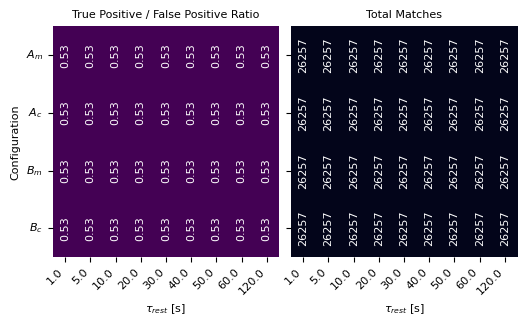

C:\Users\Ludwig\AppData\Local\Temp\ipykernel_30652\774248168.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


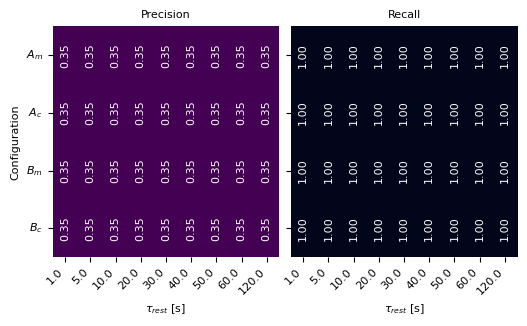

In [49]:
from matplotlib.colors import Normalize
import seaborn as sns

# --- Settings ---
freq_configs = ['cata_v11.3D_full_empiric',
                'cata_v11.3D_full_compute',
                'cata_v11.bbd_full_empiric',
                'cata_v11.bbd_full_compute']
resting_times = [1., 5., 10., 20., 30., 40., 50., 60., 120.]
base_dir = "D:/data_kavachi_both/results/"
ref_catalog_path = "D:/data_kavachi_both/results/catalog_pl.txt"
reference         = pd.read_csv(ref_catalog_path, sep='\t', parse_dates=['Starttime','Endtime'])
reference['Kavachi'] = [True if reference['BAZ'][i] >= kav_angle[0] and reference['BAZ'][i] <= kav_angle[1] else False for i in range(len(reference))]
reference['Eventtime(UTC)'] = pd.to_datetime(reference['Starttime'])  # Ensure Eventtime is in UTC

# Assume reference is already labeled with 'Kavachi' == True/False
ref_kav = reference[reference['Kavachi'] == True].copy()
ref_not = reference[reference['Kavachi'] == False].copy()

def match_and_compute_s2n(detect_df, ref_kav, ref_not, tolerance=pd.Timedelta(seconds=5)):
    detect_df = detect_df.copy()
    detect_df['Eventtime(UTC)'] = pd.to_datetime(detect_df['Eventtime(UTC)'])
    detect_df = detect_df.sort_values('Eventtime(UTC)')

    matched_kav = pd.merge_asof(detect_df, ref_kav, on='Eventtime(UTC)', direction='nearest', tolerance=tolerance)
    matched_not = pd.merge_asof(detect_df, ref_not, on='Eventtime(UTC)', direction='nearest', tolerance=tolerance)
    
    tp = matched_kav['Kavachi'].notna().sum()
    fp = matched_not['Kavachi'].notna().sum()
    s2n = tp / (fp + 1)
    return s2n, tp, fp, matched_kav, matched_not


def match_and_compute_s2n_reversed(detect_df, ref_kav, ref_not, tolerance=pd.Timedelta(seconds=5)):
    detect_df = detect_df.copy()
    detect_df['Eventtime(UTC)'] = pd.to_datetime(detect_df['Eventtime(UTC)'])
    detect_df = detect_df.sort_values('Eventtime(UTC)')

    # Match ref_kav to detections (1-to-1 match)
    matched_kav = pd.merge_asof(ref_kav.sort_values('Eventtime(UTC)'),
                                detect_df[['Eventtime(UTC)']].sort_values('Eventtime(UTC)'),
                                on='Eventtime(UTC)', 
                                direction='nearest',
                                tolerance=tolerance)
    tp = matched_kav['Eventtime(UTC)'].notna().sum()
    fn = len(ref_kav) - tp

    # Match ref_not to detections (1-to-1 match)
    matched_not = pd.merge_asof(ref_not.sort_values('Eventtime(UTC)'),
                                 detect_df[['Eventtime(UTC)']].sort_values('Eventtime(UTC)'),
                                 on='Eventtime(UTC)', 
                                 direction='nearest',
                                 tolerance=tolerance)
    fp = matched_not['Eventtime(UTC)'].notna().sum()
    tn = len(ref_not) - fp

    s2n = tp / (fp + 1)
    return s2n, tp, fp, tp, fn, matched_kav, matched_not


# --- DataFrame to store S2N ---
plotlabels = ['$A_{m}$', '$A_{c}$', '$B_{m}$', '$B_{c}$']
s2n_matrix = pd.DataFrame(index=plotlabels, columns=resting_times)
tp_matrix  = pd.DataFrame(index=plotlabels, columns=resting_times)
fp_matrix  = pd.DataFrame(index=plotlabels, columns=resting_times)
recall_rel_matrix = pd.DataFrame(index=plotlabels, columns=resting_times)
precision_matrix = pd.DataFrame(index=plotlabels, columns=resting_times)

for i, fb in enumerate(freq_configs):
    dirpath = os.path.join(base_dir, fb)
    for j, trest in enumerate(resting_times):
        if fb == 'cata_v11.3D_full_empiric':
            fname = f"cata_v11.3D_full.empiric_{trest:.1f}s_slim.pkl"
        elif fb == 'cata_v11.3D_full_compute':
            fname = f"cata_v11.3D_full_compute_{trest:.1f}s_slim.pkl"
        elif fb == 'cata_v11.bbd_full_empiric':
            fname = f"cata_v11.bbd_full.empiric_{trest:.1f}s_slim.pkl"
        elif fb == 'cata_v11.bbd_full_compute':
            fname = f"cata_v11.bbd_full.compute_{trest:.1f}s_slim.pkl"

        path = os.path.join(dirpath, fname)
        if os.path.exists(path):
            df = pd.read_pickle(path)
            # s2n, tp, fp, matched_kav, matched_not = match_and_compute_s2n(df, ref_kav, ref_not,tolerance=pd.Timedelta(seconds=5))
            s2n, tp, fp, tn, fn, matched_kav, matched_not = match_and_compute_s2n_reversed(df, ref_kav, ref_not,tolerance=pd.Timedelta(seconds=5))
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall_rel = tp / (len(ref_kav) if len(ref_kav) > 0 else 0)
            s2n_matrix.loc[plotlabels[i], trest] = s2n
            tp_matrix.loc[plotlabels[i], trest] = tp
            fp_matrix.loc[plotlabels[i], trest] = fp
            recall_rel_matrix.loc[plotlabels[i], trest] = recall_rel
            precision_matrix.loc[plotlabels[i], trest] = precision
        else:
            print(f"Missing file: {path}")
            s2n_matrix.loc[plotlabels[i], trest] = np.nan
tot_events = tp_matrix + fp_matrix

plt.figure(figsize=(6, 3))
gs = gridspec.GridSpec(1, 2, wspace=0.05)
ax = plt.subplot(gs[0])
ax = sns.heatmap(
    s2n_matrix.astype(float),
    annot=True,
    annot_kws={"size": fontsizelegend, "rotation": 90},
    fmt=".2f",
    cmap="viridis",
    # linewidths=0.5,
    # linecolor='gray',
    cbar=False
    # cbar_kws={"label": "S2N score"}
)
ax.set_xlabel("$\\tau_{rest}$ [s]", fontsize=fontsizelegend)
ax.set_ylabel("Configuration", fontsize=fontsizelegend)
ax.set_title("True Positive / False Positive Ratio", fontsize=fontsizelegend)
ax.tick_params(axis='y', labelleft=True, labelsize=fontsizelegend, labelrotation=0)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsizelegend)
ax.tick_params(axis='x', labelsize=fontsizelegend)
# ax.set_

ax1 = plt.subplot(gs[1])
ax1 = sns.heatmap(
    tot_events.astype(float),
    annot=True,
    annot_kws={"size": fontsizelegend, "rotation": 90},
    fmt=".0f",
    # cmap="viridis",
    # linewidths=0.5,
    # linecolor='gray',
    cbar=False
)

ax1.set_xlabel("$\\tau_{rest}$ [s]", fontsize=fontsizelegend)
ax1.tick_params(axis='y', labelleft=False)
ax1.tick_params(axis='x', labelsize=fontsizelegend)
ax1.set_title("Total Matches", fontsize=fontsizelegend)
[plt.setp(a.get_xticklabels(), rotation=45, ha='right', fontsize=fontsizelegend) for a in [ax, ax1]]


plt.tight_layout()
plt.savefig(os.path.join(rootouts, 'thesis', 'results.reference.s2n_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- Recall and Precision ---
plt.figure(figsize=(6, 3))
gs = gridspec.GridSpec(1, 2, wspace=0.05)
ax = plt.subplot(gs[0])
ax = sns.heatmap(
    precision_matrix.astype(float),
    annot=True,
    annot_kws={"size": fontsizelegend, "rotation": 90},
    fmt=".2f",
    cmap="viridis",
    # linewidths=0.5,
    # linecolor='gray',
    cbar=False
    # cbar_kws={"label": "S2N score"}
)
ax.set_xlabel("$\\tau_{rest}$ [s]", fontsize=fontsizelegend)
ax.set_ylabel("Configuration", fontsize=fontsizelegend)
ax.set_title("Precision", fontsize=fontsizelegend)
ax.tick_params(axis='y', labelleft=True, labelsize=fontsizelegend, labelrotation=0)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsizelegend)
ax.tick_params(axis='x', labelsize=fontsizelegend)
# ax.set_

ax1 = plt.subplot(gs[1])
ax1 = sns.heatmap(
    recall_rel_matrix.astype(float),
    annot=True,
    annot_kws={"size": fontsizelegend, "rotation": 90},
    fmt=".2f",
    # cmap="viridis",
    # linewidths=0.5,
    # linecolor='gray',
    cbar=False
)

ax1.set_xlabel("$\\tau_{rest}$ [s]", fontsize=fontsizelegend)
ax1.tick_params(axis='y', labelleft=False)
ax1.tick_params(axis='x', labelsize=fontsizelegend)
ax1.set_title("Recall", fontsize=fontsizelegend)
[plt.setp(a.get_xticklabels(), rotation=45, ha='right', fontsize=fontsizelegend) for a in [ax, ax1]]


plt.tight_layout()
plt.savefig(os.path.join(rootouts, 'thesis', 'results.reference.precisionrecall.png'), dpi=300, bbox_inches='tight')
plt.show()


In [51]:
# len(reference)
# len(ref_kav), len(ref_not), len(ref_kav) + len(ref_not), len(reference)
print(f"ref: {len(reference)}, kav: {len(ref_kav)}, not: {len(ref_not)}, tp:{tp}, fp:{fp}, tn:{tn}, fn:{fn}")

ref: 26257, kav: 9078, not: 17179, tp:9078, fp:17179, tn:9078, fn:0


#### RSAM

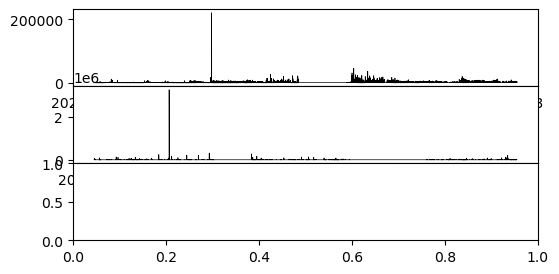

In [56]:
rsam = Stream()
rsam11 = pd.read_pickle(os.path.join(rootouts,'rsam_KAV11.pkl'))
rsam00 = pd.read_pickle(os.path.join(rootouts,'rsam_KAV00.pkl'))
# rsam.append(Trace(data=rsam11))
rsam11['timedt'] = pd.to_datetime(rsam11['time'])
rsam00['timedt'] = pd.to_datetime(rsam00['time'])

rsam.append(Trace(data=rsam11['rsam'].values))
rsam[0].stats.starttime = rsam11['timedt'].values[0]
# rsam[0].stats.endtime = rsam11['timedt'].values[-1]
rsam[0].stats.sampling_rate = 1/60

fig = plt.figure(figsize=(6, 3))
gs = gridspec.GridSpec(3,1, height_ratios=[1, 1, 1], hspace=0.0)
ax0, ax1, ax2 = [fig.add_subplot(gs[i]) for i in range(3)]

ax0.plot(rsam11['timedt'].values, rsam11['rsam'].values, color='black', linewidth=0.5)
ax1.plot(rsam00['timedt'].values, rsam00['rsam'].values, color='black', linewidth=0.5)



#### Plot checkerboard like plot.

In [55]:
def sliding_lagged_crosscorr(x, y, interval='1H', window_units=6, max_lag_units=2, step_units=1):
    """
    Compute lagged cross-correlation between x and y in a sliding window.
    
    Parameters
    ----------
    x, y : pandas Series
        Time series to compare. Must have datetime index and same frequency.
    interval : str
        Pandas-compatible interval string (e.g., '10min', '1H', '1D', '7D').
    window_units : int
        Window size in number of intervals (e.g., 6 x '1H' = 6 hours window).
    max_lag_units : int
        Max lag to consider in number of intervals.
    step_units : int
        Step size for sliding window in number of intervals.
    
    Returns
    -------
    DataFrame
        DataFrame with columns: 'max_corr', 'best_lag' and index as center time.
    """
    x = x.sort_index().resample(interval).mean()
    y = y.sort_index().resample(interval).mean()
    
    # Drop NaNs
    df = pd.concat([x, y], axis=1, join='inner').dropna()
    x, y = df.iloc[:, 0], df.iloc[:, 1]

    window = window_units
    max_lag = max_lag_units
    step = step_units

    results = []
    lags = np.arange(-max_lag, max_lag + 1)

    for i in range(0, len(x) - window, step):
        x_win = x.iloc[i:i+window].values
        y_win = y.iloc[i:i+window].values
        
        x_win -= np.mean(x_win)
        y_win -= np.mean(y_win)
        
        ccf = correlate(x_win, y_win, mode='full')
        std_product = np.std(x_win) * np.std(y_win)
        if std_product == 0:
            results.append({
                'time': x.index[i + window // 2],
                'max_corr': np.nan,
                'best_lag': np.nan
            })
            continue
        ccf /= (std_product * len(x_win))


        lag_idx = np.argmax(ccf)
        best_lag = lag_idx - (len(x_win) - 1)

        if abs(best_lag) <= max_lag:
            results.append({
                'time': x.index[i + window // 2],
                'max_corr': ccf[lag_idx],
                'best_lag': best_lag
            })
        else:
            results.append({
                'time': x.index[i + window // 2],
                'max_corr': np.nan,
                'best_lag': np.nan
            })

    return pd.DataFrame(results).set_index('time')


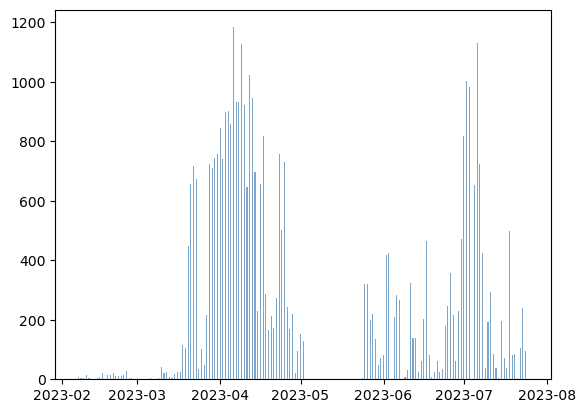

In [54]:
cata = pd.read_pickle(os.path.join(rootouts, 'cata_v11.3D_full_empiric', 'cata_v11.3D_full.empiric_20.0s_slim.pkl'))
# Compute daily event counts from cata
daily_counts = cata['Eventtime(UTC)'].dt.date.value_counts().sort_index() 
df_cnts = pd.DataFrame({'Date': daily_counts.index, 'Counts': daily_counts.values})
ax = plt.bar(df_cnts['Date'], df_cnts['Counts'], width=0.4, color='steelblue', alpha=0.7)



### Assign traces for crosscorrelation: RSAM and detections

In [57]:
# prepare rsam and catalog for cross-correlation at sampling rate of 1H
rsam11_10m = rsam11.set_index('timedt')['rsam'].resample('10min').sum().dropna()
rsam00_10m = rsam00.set_index('timedt')['rsam'].resample('10min').sum().dropna()

rsam11_1h = rsam11.set_index('timedt')['rsam'].resample('1H').mean().dropna()
rsam00_1h = rsam00.set_index('timedt')['rsam'].resample('1H').mean().dropna()

rsam11_12h = rsam11.set_index('timedt')['rsam'].resample('12H').mean().dropna()
rsam00_12h = rsam00.set_index('timedt')['rsam'].resample('12H').mean().dropna()

rsam11_1d = rsam11.set_index('timedt')['rsam'].resample('1D').mean().dropna()
rsam00_1d = rsam00.set_index('timedt')['rsam'].resample('1D').mean().dropna()

rsam11_5d = rsam11.set_index('timedt')['rsam'].resample('5D').mean().dropna()
rsam00_5d = rsam00.set_index('timedt')['rsam'].resample('5D').mean().dropna()

# Define the angle range for Kavachi
reference = pd.read_csv(os.path.join(rootouts, 'catalog_pl.txt'), sep='\t', parse_dates=['Starttime','Endtime'])
ref = reference[(reference['BAZ'] >= kav_angle[0]) & (reference['BAZ'] <= kav_angle[1])]
ref_10m = ref['Starttime'].dt.floor('10min').value_counts().sort_index()
ref_1h = ref['Starttime'].dt.floor('1H').value_counts().sort_index()
ref_12h = ref['Starttime'].dt.floor('12H').value_counts().sort_index()
ref_1d = ref['Starttime'].dt.floor('1D').value_counts().sort_index()
ref_5d = ref['Starttime'].dt.floor('5D').value_counts().sort_index()




# Prepare catalog: count events per hour
# Compute event counts per hour from catalog 'cata'
cata_10m = cata['Eventtime(UTC)'].dt.floor('10min').value_counts().sort_index()
cata_1h = cata['Eventtime(UTC)'].dt.floor('1H').value_counts().sort_index()
cata_12h = cata['Eventtime(UTC)'].dt.floor('12H').value_counts().sort_index()
cata_1d = cata['Eventtime(UTC)'].dt.floor('1D').value_counts().sort_index()
cata_5d = cata['Eventtime(UTC)'].dt.floor('5D').value_counts().sort_index()

# Prepare the data for catalogs with different configurations as well
cata_bbd = pd.read_pickle(os.path.join(rootouts, 'cata_v11.bbd_full_empiric', 'cata_v11.bbd_full.empiric_20.0s_slim.pkl'))
cata_bbd_10m = cata_bbd['Eventtime(UTC)'].dt.floor('10min').value_counts().sort_index()
cata_bbd_1h = cata_bbd['Eventtime(UTC)'].dt.floor('1H').value_counts().sort_index()
cata_bbd_12h = cata_bbd['Eventtime(UTC)'].dt.floor('12H').value_counts().sort_index()
cata_bbd_1d = cata_bbd['Eventtime(UTC)'].dt.floor('1D').value_counts().sort_index()
cata_bbd_5d = cata_bbd['Eventtime(UTC)'].dt.floor('5D').value_counts().sort_index()

cata_bbdcomp = pd.read_pickle(os.path.join(rootouts, 'cata_v11.bbd_full_compute', 'cata_v11.bbd_full.compute_20.0s_slim.pkl'))
cata_bbdcomp_10m = cata_bbdcomp['Eventtime(UTC)'].dt.floor('10min').value_counts().sort_index()
cata_bbdcomp_1h = cata_bbdcomp['Eventtime(UTC)'].dt.floor('1H').value_counts().sort_index()
cata_bbdcomp_12h = cata_bbdcomp['Eventtime(UTC)'].dt.floor('12H').value_counts().sort_index()
cata_bbdcomp_1d = cata_bbdcomp['Eventtime(UTC)'].dt.floor('1D').value_counts().sort_index()
cata_bbdcomp_5d = cata_bbdcomp['Eventtime(UTC)'].dt.floor('5D').value_counts().sort_index()

cata_3dcomp = pd.read_pickle(os.path.join(rootouts, 'cata_v11.3D_full_compute', 'cata_v11.3D_full_compute_20.0s_slim.pkl'))
cata_3dcomp_10m = cata_3dcomp['Eventtime(UTC)'].dt.floor('10min').value_counts().sort_index()
cata_3dcomp_1h = cata_3dcomp['Eventtime(UTC)'].dt.floor('1H').value_counts().sort_index()
cata_3dcomp_12h = cata_3dcomp['Eventtime(UTC)'].dt.floor('12H').value_counts().sort_index()
cata_3dcomp_1d = cata_3dcomp['Eventtime(UTC)'].dt.floor('1D').value_counts().sort_index()
cata_3dcomp_5d = cata_3dcomp['Eventtime(UTC)'].dt.floor('5D').value_counts().sort_index()

# Compute cross-correlation for different time intervals
ccf_10m = sliding_lagged_crosscorr(rsam11_10m, cata_10m, interval='10min', window_units=24, max_lag_units=2, step_units=1)
ccf_1h = sliding_lagged_crosscorr(rsam11_1h, cata_1h, interval='1H', window_units=10, max_lag_units=2, step_units=1)
ccf_12h = sliding_lagged_crosscorr(rsam11_12h, cata_12h, interval='12H', window_units=8, max_lag_units=2, step_units=1)
ccf_1d = sliding_lagged_crosscorr(rsam11_1d, cata_1d, interval='1D', window_units=7, max_lag_units=2, step_units=1)
ccf_5d = sliding_lagged_crosscorr(rsam11_5d, cata_5d, interval='5D', window_units=4, max_lag_units=2, step_units=1)

ccf_ref_10m = sliding_lagged_crosscorr(ref_10m, cata_10m, interval='10min', window_units=24, max_lag_units=2, step_units=1)
ccf_ref_1h = sliding_lagged_crosscorr(ref_1h, cata_1h, interval='1H', window_units=10, max_lag_units=2, step_units=1)
ccf_ref_12h = sliding_lagged_crosscorr(ref_12h, cata_12h, interval='12H', window_units=8, max_lag_units=2, step_units=1)
ccf_ref_1d = sliding_lagged_crosscorr(ref_1d, cata_1d, interval='1D', window_units=7, max_lag_units=2, step_units=1)
ccf_ref_5d = sliding_lagged_crosscorr(ref_5d, cata_5d, interval='5D', window_units=4, max_lag_units=2, step_units=1)


### Spearman matrix

C:\Users\Ludwig\AppData\Local\Temp\ipykernel_22192\3126552129.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


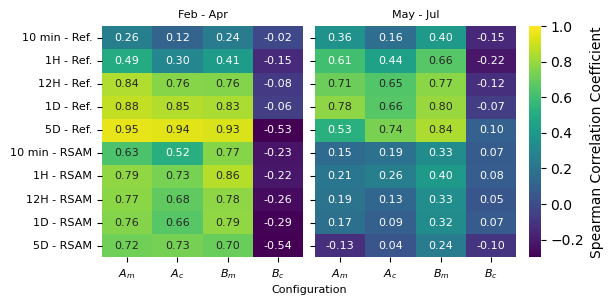

In [31]:
# --- Spearmann
start, end = seasons[0][0], seasons[0][1]

yinputs = [ref_10m, ref_1h, ref_12h, ref_1d, ref_5d,
         rsam11_10m, rsam11_1h, rsam11_12h, rsam11_1d, rsam11_5d]
xinputs = [[cata_10m, cata_1h, cata_12h, cata_1d, cata_5d,
           cata_10m, cata_1h, cata_12h, cata_1d, cata_5d],
            [cata_3dcomp_10m, cata_3dcomp_1h, cata_3dcomp_12h, cata_3dcomp_1d, cata_3dcomp_5d,
           cata_3dcomp_10m, cata_3dcomp_1h, cata_3dcomp_12h, cata_3dcomp_1d, cata_3dcomp_5d],
           [cata_bbd_10m, cata_bbd_1h, cata_bbd_12h, cata_bbd_1d, cata_bbd_5d,
           cata_bbd_10m, cata_bbd_1h, cata_bbd_12h, cata_bbd_1d, cata_bbd_5d],
           [cata_bbdcomp_10m, cata_bbdcomp_1h, cata_bbdcomp_12h, cata_bbdcomp_1d, cata_bbdcomp_5d,
           cata_bbdcomp_10m, cata_bbdcomp_1h, cata_bbdcomp_12h, cata_bbdcomp_1d, cata_bbdcomp_5d]]

yinputs_ep1 = [y[(y.index >= start) & (y.index <= end)] for y in yinputs]
xinputs_ep1 = [[x[(x.index >= start) & (x.index <= end)] for x in xs] for xs in xinputs]

xinputs_ep2 = [[x[(x.index >= seasons[1][0]) & (x.index <= seasons[1][1])] for x in xs] for xs in xinputs]
yinputs_ep2 = [y[(y.index >= seasons[1][0]) & (y.index <= seasons[1][1])] for y in yinputs]

ylabels_spearman_matrix = ['10 min - Ref.', '1H - Ref.', '12H - Ref.', '1D - Ref.', '5D - Ref.',
                          '10 min - RSAM', '1H - RSAM', '12H - RSAM', '1D - RSAM', '5D - RSAM']
xlabels_spearman_matrix = ['$A_{m}$', '$A_{c}$', '$B_{m}$', '$B_{c}$']

spearman_matrix_ep1 = pd.DataFrame(index=ylabels_spearman_matrix, columns=xlabels_spearman_matrix)
spearman_matrix_ep2 = pd.DataFrame(index=ylabels_spearman_matrix, columns=xlabels_spearman_matrix)

def compute_spearman_matrix(xinputs, yinputs, matrix):
     for i, xlist in enumerate(xinputs):
          for j, y in enumerate(yinputs):
               x = xlist[j]
     
               aligned = pd.concat([x, y], axis=1).dropna()
               if aligned.empty:
                    spearman_value = np.nan
               else:
                    spearman_value, _ = spearmanr(aligned.iloc[:, 0], aligned.iloc[:, 1])
               matrix.iloc[j, i] = spearman_value
     
     return matrix

spearman_matrix_v1 = compute_spearman_matrix(xinputs_ep1, yinputs_ep1, spearman_matrix_ep1)
spearman_matrix_v2 = compute_spearman_matrix(xinputs_ep2, yinputs_ep2, spearman_matrix_ep2)


fig = plt.figure(figsize=(6, 3))
gs = gridspec.GridSpec(1,2, width_ratios=[.8, 1], wspace=0.05)
ax = fig.add_subplot(gs[0])
ax.set_title("Feb - Apr", fontsize=fontsizelegend)

sns.heatmap(
     spearman_matrix_v1.astype(float),
     annot=True,
     annot_kws={"size": fontsizelegend, "rotation": 0},
     fmt=".2f",
     cbar=False,
     cmap="viridis",
     # linewidths=0.5,
     # linecolor='gray',
     cbar_kws={"label": "Spearman Correlation Coefficient"},
     ax = ax,
     vmin=-.3, vmax=1.0
)
ax.tick_params(axis='y', labelleft=True, labelsize=fontsizelegend)#, pad=5)

ax2 = fig.add_subplot(gs[1])
ax2.set_title("May - Jul", fontsize=fontsizelegend)
sns.heatmap(
     spearman_matrix_v2.astype(float),
     annot=True,
     annot_kws={"size": fontsizelegend, "rotation": 0},
     fmt=".2f",
     cmap="viridis",
     # linewidths=0.5,
     # linecolor='gray',
     cbar_kws={"label": "Spearman Correlation Coefficient"},
     ax = ax2,
     vmin=-.3, vmax=1.0
)
# - Set superlabel for both x axis
fig.text(0.47, 0.001, "Configuration", ha='center', va='center', fontsize=fontsizelegend)


ax2.tick_params(axis='y', labelleft=False, labelsize=fontsizelegend)
[a.tick_params(axis='x', labelsize=fontsizelegend) for a in [ax, ax2]]
fig.align_ylabels([ax, ax2])
plt.tight_layout()
plt.savefig(os.path.join(rootouts, 'thesis', 'spearman_correlation_matrix.png'), dpi=300, bbox_inches='tight')

### Assign traces for crosscorrelation and plotting

In [58]:
# Prepare the data for season-wise plotting
cata_10m_s1     = cata_10m[(cata_10m.index >= seasons[0][0]) & (cata_10m.index <= seasons[0][1])]
cata_10m_s2     = cata_10m[(cata_10m.index >= seasons[1][0]) & (cata_10m.index <= seasons[1][1])]
rsam11_10m_s1   = rsam11_10m[(rsam11_10m.index >= seasons[0][0]) & (rsam11_10m.index <= seasons[0][1])]
rsam11_10m_s2   = rsam11_10m[(rsam11_10m.index >= seasons[1][0]) & (rsam11_10m.index <= seasons[1][1])]

ccf_10m_s1      = ccf_10m[(ccf_10m.index >= seasons[0][0]) & (ccf_10m.index <= seasons[0][1])]
ccf_10m_s2      = ccf_10m[(ccf_10m.index >= seasons[1][0]) & (ccf_10m.index <= seasons[1][1])]
ccf_1h_s1       = ccf_1h[(ccf_1h.index >= seasons[0][0]) & (ccf_1h.index <= seasons[0][1])]
ccf_1h_s2       = ccf_1h[(ccf_1h.index >= seasons[1][0]) & (ccf_1h.index <= seasons[1][1])]
ccf_12h_s1      = ccf_12h[(ccf_12h.index >= seasons[0][0]) & (ccf_12h.index <= seasons[0][1])]
ccf_12h_s2      = ccf_12h[(ccf_12h.index >= seasons[1][0]) & (ccf_12h.index <= seasons[1][1])]
ccf_1d_s1       = ccf_1d[(ccf_1d.index >= seasons[0][0]) & (ccf_1d.index <= seasons[0][1])]
ccf_1d_s2       = ccf_1d[(ccf_1d.index >= seasons[1][0]) & (ccf_1d.index <= seasons[1][1])]
ccf_5d_s1       = ccf_5d[(ccf_5d.index >= seasons[0][0]) & (ccf_5d.index <= seasons[0][1])]
ccf_5d_s2       = ccf_5d[(ccf_5d.index >= seasons[1][0]) & (ccf_5d.index <= seasons[1][1])]

ref             = reference[(reference['BAZ'] >= kav_angle[0]) & (reference['BAZ'] <= kav_angle[1])]
[ref_10m, ref_1h, ref_12h, ref_1d, ref_5d] = [
    ref['Starttime'].dt.floor(interval).value_counts().sort_index() for interval in ['10min', '1H', '12H', '1D', '5D']]

[ref_10m_s1, ref_1h_s1, ref_12h_s1, ref_1d_s1, ref_5d_s1] = [
    refdf[(refdf.index >= seasons[0][0]) & (refdf.index <= seasons[0][1])] for refdf in [ref_10m, ref_1h, ref_12h, ref_1d, ref_5d]]
[ref_10m_s2, ref_1h_s2, ref_12h_s2, ref_1d_s2, ref_5d_s2] = [
    refdf[(refdf.index >= seasons[1][0]) & (refdf.index <= seasons[1][1])] for refdf in [ref_10m, ref_1h, ref_12h, ref_1d, ref_5d]]

# Prepare listofcorr and listoflabels as before
ccf_Bm_10m      = sliding_lagged_crosscorr(rsam11_10m, cata_bbd_10m, interval='10min', window_units=24, max_lag_units=2, step_units=1)
ccf_Bm_1h       = sliding_lagged_crosscorr(rsam11_1h, cata_bbd_1h, interval='1H', window_units=10, max_lag_units=2, step_units=1)
ccf_Bm_12h      = sliding_lagged_crosscorr(rsam11_12h, cata_bbd_12h, interval='12H', window_units=8, max_lag_units=2, step_units=1)
ccf_Bm_1d       = sliding_lagged_crosscorr(rsam11_1d, cata_bbd_1d, interval='1D', window_units=7, max_lag_units=2, step_units=1)
ccf_Bm_5d       = sliding_lagged_crosscorr(rsam11_5d, cata_bbd_5d, interval='5D', window_units=4, max_lag_units=2, step_units=1)

# [cata_bbd_10m_s1, cata_bbd_10m_s2] = [cata_bbd_10m[(cata_bbd_10m.index >= s[0]) & (cata_bbd_10m.index <= s[1])] for s in seasons]
cata_bbd_10m_s1 = cata_bbd_10m[(cata_bbd_10m.index >= seasons[0][0]) & (cata_bbd_10m.index <= seasons[0][1])]
cata_bbd_10m_s2 = cata_bbd_10m[(cata_bbd_10m.index >= seasons[1][0]) & (cata_bbd_10m.index <= seasons[1][1])]
cata_bbd_1h_s1  = cata_bbd_1h[(cata_bbd_1h.index >= seasons[0][0]) & (cata_bbd_1h.index <= seasons[0][1])]
cata_bbd_1h_s2  = cata_bbd_1h[(cata_bbd_1h.index >= seasons[1][0]) & (cata_bbd_1h.index <= seasons[1][1])]
cata_bbd_12h_s1 = cata_bbd_12h[(cata_bbd_12h.index >= seasons[0][0]) & (cata_bbd_12h.index <= seasons[0][1])]
cata_bbd_12h_s2 = cata_bbd_12h[(cata_bbd_12h.index >= seasons[1][0]) & (cata_bbd_12h.index <= seasons[1][1])]
cata_bbd_1d_s1  = cata_bbd_1d[(cata_bbd_1d.index >= seasons[0][0]) & (cata_bbd_1d.index <= seasons[0][1])]
cata_bbd_1d_s2  = cata_bbd_1d[(cata_bbd_1d.index >= seasons[1][0]) & (cata_bbd_1d.index <= seasons[1][1])]
cata_bbd_5d_s1  = cata_bbd_5d[(cata_bbd_5d.index >= seasons[0][0]) & (cata_bbd_5d.index <= seasons[0][1])]
cata_bbd_5d_s2  = cata_bbd_5d[(cata_bbd_5d.index >= seasons[1][0]) & (cata_bbd_5d.index <= seasons[1][1])]

ccf_Bm_ref_10m = sliding_lagged_crosscorr(ref_10m, cata_bbd_10m, interval='10min', window_units=24, max_lag_units=2, step_units=1)
ccf_Bm_ref_1h  = sliding_lagged_crosscorr(ref_1h, cata_bbd_1h, interval='1H', window_units=10, max_lag_units=2, step_units=1)
ccf_Bm_ref_12h = sliding_lagged_crosscorr(ref_12h, cata_bbd_12h, interval='12H', window_units=8, max_lag_units=2, step_units=1)
ccf_Bm_ref_1d  = sliding_lagged_crosscorr(ref_1d, cata_bbd_1d, interval='1D', window_units=7, max_lag_units=2, step_units=1)
ccf_Bm_ref_5d  = sliding_lagged_crosscorr(ref_5d, cata_bbd_5d, interval='5D', window_units=4, max_lag_units=2, step_units=1)

[ccf_Bm_ref_10m_s1, ccf_Bm_ref_1h_s1, ccf_Bm_ref_12h_s1, ccf_Bm_ref_1d_s1, ccf_Bm_ref_5d_s1] = [
    ccf[(ccf.index >= seasons[0][0]) & (ccf.index <= seasons[0][1])] for ccf in
    [ccf_Bm_ref_10m, ccf_Bm_ref_1h, ccf_Bm_ref_12h, ccf_Bm_ref_1d, ccf_Bm_ref_5d]]
[ccf_Bm_ref_10m_s2, ccf_Bm_ref_1h_s2, ccf_Bm_ref_12h_s2, ccf_Bm_ref_1d_s2, ccf_Bm_ref_5d_s2] = [
    ccf[(ccf.index >= seasons[1][0]) & (ccf.index <= seasons[1][1])] for ccf in
    [ccf_Bm_ref_10m, ccf_Bm_ref_1h, ccf_Bm_ref_12h, ccf_Bm_ref_1d, ccf_Bm_ref_5d]]

[ccf_ref_10m_s1, ccf_ref_1h_s1, ccf_ref_12h_s1, ccf_ref_1d_s1, ccf_ref_5d_s1] = [
    ccf[(ccf.index >= seasons[0][0]) & (ccf.index <= seasons[0][1])] for ccf in
    [ccf_ref_10m, ccf_ref_1h, ccf_ref_12h, ccf_ref_1d, ccf_ref_5d]]

[ccf_ref_10m_s2, ccf_ref_1h_s2, ccf_ref_12h_s2, ccf_ref_1d_s2, ccf_ref_5d_s2] = [
    ccf[(ccf.index >= seasons[1][0]) & (ccf.index <= seasons[1][1])] for ccf in
    [ccf_ref_10m, ccf_ref_1h, ccf_ref_12h, ccf_ref_1d, ccf_ref_5d]]

### Plot traces and Correlation

#### single plots

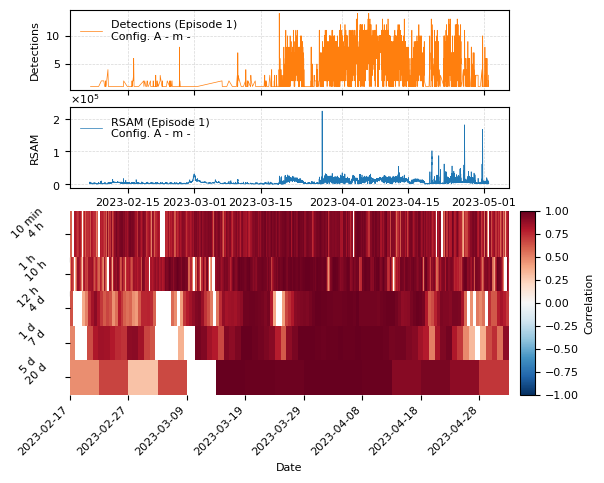

In [242]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import numpy as np
import pandas as pd

# Prepare listofcorr and listoflabels as before
listofcorr = [ccf_10m_s1, ccf_1h_s1, ccf_12h_s1, ccf_1d_s1, ccf_5d_s1]
listoflabels = ['10 min \n 4 h ', '1 h\n10 h', '12 h\n 4 d', '1 d\n 7 d', '5 d\n20 d']

# --- Set up a GridSpec with extra column for colorbar ---
fig = plt.figure(figsize=(6, 5))  # widen slightly to fit colorbar
gs = gridspec.GridSpec(9, 2, width_ratios=[30, 1], height_ratios=[.7, .15, .7, .2, 0.4, .3, .3, .3, .3], hspace=0.0, wspace=0.05)

# --- Panel: Detections ---
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(cata_10m_s1.index, cata_10m_s1.values, label='Detections (Episode 1)\nConfig. A - m -', color='C1', linewidth=.5)
ax0.set_ylabel('Detections', fontsize=fontsizelegend)
ax0.tick_params(axis='x', labelbottom=False)
ax0.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax0.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax0.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panel: RSAM ---
ax1 = fig.add_subplot(gs[2, 0], sharex=ax0)
ax1.plot(rsam11_10m_s1.index, rsam11_10m_s1.values, label='RSAM (Episode 1)\nConfig. A - m -', color='C0', linewidth=.5)
ax1.set_ylabel('RSAM', fontsize=fontsizelegend)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.tick_params(axis='x', labelbottom=True, labelsize=fontsizelegend)
# for label in ax1.get_xticklabels():
#     label.set_fontsize(8)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax1.yaxis.offsetText.set_fontsize(8)
ax1.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax1.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panels: Heatmaps ---
heat_axes = [fig.add_subplot(gs[i, 0]) for i in range(4, 9)]
heatmap_refs = []  # collect for colorbar reference

for i, (ax, corr, label) in enumerate(zip(heat_axes, listofcorr, listoflabels)):
    hm = sns.heatmap(
        corr[['max_corr']].T,
        ax=ax,
        xticklabels=20,
        cbar=False,
        cmap="RdBu_r",
        vmin=-1, vmax=1,
    )
    heatmap_refs.append(hm)
    ax.set_ylabel(label, fontsize=8, rotation=45)
    ax.tick_params(axis='x', labelbottom=(i == 4), rotation=45)
    ax.tick_params(axis='y', labelsize=8, labelleft=False)

# Format final x-axis
xticks = np.arange(0, len(listofcorr[-1]), step=2)
xticklabels = [listofcorr[-1].index[i].strftime("%Y-%m-%d") for i in xticks]
heat_axes[-1].set_xticks(xticks)
heat_axes[-1].set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=8)
heat_axes[-1].set_xlabel("Date", fontsize=fontsizelegend)

# --- Shared colorbar on the right of heatmaps ---
from mpl_toolkits.axes_grid1 import make_axes_locatable
cax = fig.add_subplot(gs[4:9, 1])  # span rows 4 to 8 in the second column
cbar = plt.colorbar(heatmap_refs[-1].collections[0], cax=cax)
cbar.set_label("Correlation", fontsize=8)
cbar.ax.tick_params(labelsize=8)

fig.align_ylabels()
plt.savefig(os.path.join(rootouts, 'thesis', 'results.corr.rsam.ep1.png'), dpi=300, bbox_inches='tight')
plt.show()


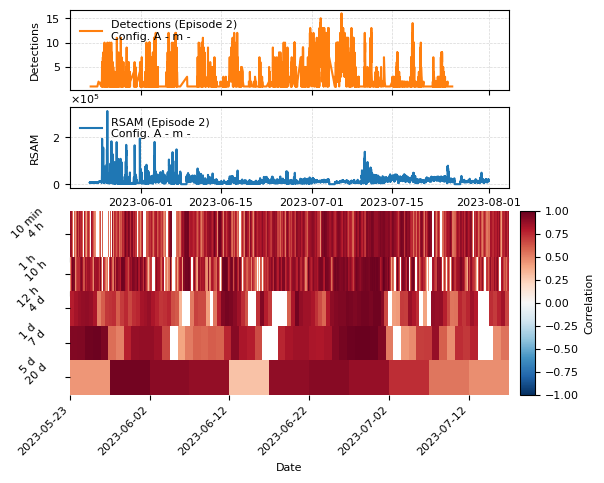

In [243]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import numpy as np
import pandas as pd

# Prepare listofcorr and listoflabels as before
listofcorr = [ccf_10m_s2, ccf_1h_s2, ccf_12h_s2, ccf_1d_s2, ccf_5d_s2]
listoflabels = ['10 min \n 4 h ', '1 h\n10 h', '12 h\n 4 d', '1 d\n 7 d', '5 d\n20 d']

# --- Set up a GridSpec with extra column for colorbar ---
fig = plt.figure(figsize=(6, 5))  # widen slightly to fit colorbar
gs = gridspec.GridSpec(9, 2, width_ratios=[30, 1], height_ratios=[.7, .15, .7, .2, 0.4, .3, .3, .3, .3], hspace=0.0, wspace=0.05)

# --- Panel: Detections ---
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(cata_10m_s2.index, cata_10m_s2.values, label='Detections (Episode 2) \nConfig. A - m -', color='C1')
ax0.set_ylabel('Detections', fontsize=fontsizelegend)
ax0.tick_params(axis='x', labelbottom=False)
ax0.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax0.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax0.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panel: RSAM ---
ax1 = fig.add_subplot(gs[2, 0], sharex=ax0)
ax1.plot(rsam11_10m_s2.index, rsam11_10m_s2.values, label='RSAM (Episode 2) \nConfig. A - m -', color='C0')
ax1.set_ylabel('RSAM', fontsize=fontsizelegend)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.tick_params(axis='x', labelbottom=True, labelsize=fontsizelegend)
for label in ax1.get_xticklabels():
    label.set_fontsize(8)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax1.yaxis.offsetText.set_fontsize(8)
ax1.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax1.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panels: Heatmaps ---
heat_axes = [fig.add_subplot(gs[i, 0]) for i in range(4, 9)]
heatmap_refs = []  # collect for colorbar reference

for i, (ax, corr, label) in enumerate(zip(heat_axes, listofcorr, listoflabels)):
    hm = sns.heatmap(
        corr[['max_corr']].T,
        ax=ax,
        xticklabels=20,
        cbar=False,
        cmap="RdBu_r",
        vmin=-1, vmax=1,
    )
    heatmap_refs.append(hm)
    ax.set_ylabel(label, fontsize=8, rotation=45)
    ax.tick_params(axis='x', labelbottom=(i == 4), rotation=45)
    ax.tick_params(axis='y', labelsize=8, labelleft=False)

# Format final x-axis
xticks = np.arange(0, len(listofcorr[-1]), step=2)
xticklabels = [listofcorr[-1].index[i].strftime("%Y-%m-%d") for i in xticks]
heat_axes[-1].set_xticks(xticks)
heat_axes[-1].set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=8)
heat_axes[-1].set_xlabel("Date", fontsize=fontsizelegend)

# --- Shared colorbar on the right of heatmaps ---
from mpl_toolkits.axes_grid1 import make_axes_locatable
cax = fig.add_subplot(gs[4:9, 1])  # span rows 4 to 8 in the second column
cbar = plt.colorbar(heatmap_refs[-1].collections[0], cax=cax)
cbar.set_label("Correlation", fontsize=8)
cbar.ax.tick_params(labelsize=8)

fig.align_ylabels()
plt.savefig(os.path.join(rootouts, 'thesis', 'results.corr.rsam.ep2.png'), dpi=300, bbox_inches='tight')
plt.show()


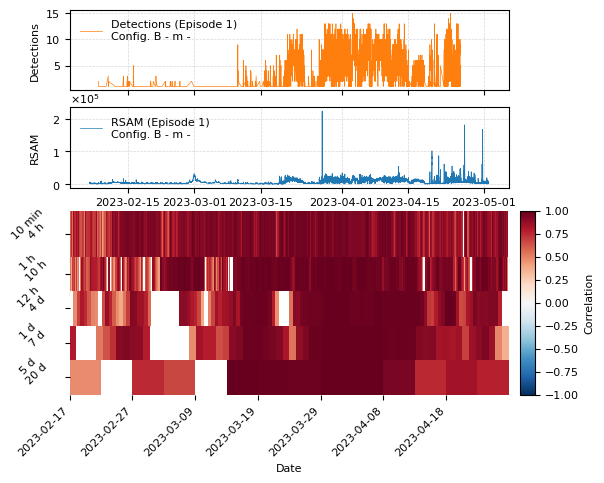

In [248]:
[ccf_Bm_10m_s1, ccf_Bm_1h_s1, ccf_Bm_12h_s1, ccf_Bm_1d_s1, ccf_Bm_5d_s1] = [ccf[(ccf.index >= seasons[0][0]) & (ccf.index <= seasons[0][1])] for ccf in [ccf_Bm_10m, ccf_Bm_1h, ccf_Bm_12h, ccf_Bm_1d, ccf_Bm_5d]]
[ccf_Bm_10m_s2, ccf_Bm_1h_s2, ccf_Bm_12h_s2, ccf_Bm_1d_s2, ccf_Bm_5d_s2] = [ccf[(ccf.index >= seasons[1][0]) & (ccf.index <= seasons[1][1])] for ccf in [ccf_Bm_10m, ccf_Bm_1h, ccf_Bm_12h, ccf_Bm_1d, ccf_Bm_5d]]


listofcorr = [ccf_Bm_10m_s1, ccf_Bm_1h_s1, ccf_Bm_12h_s1, ccf_Bm_1d_s1, ccf_Bm_5d_s1]
listoflabels = ['10 min \n 4 h ', '1 h\n10 h', '12 h\n 4 d', '1 d\n 7 d', '5 d\n20 d']

# --- Set up a GridSpec with extra column for colorbar ---
fig = plt.figure(figsize=(6, 5))  # widen slightly to fit colorbar
gs = gridspec.GridSpec(9, 2, width_ratios=[30, 1], height_ratios=[.7, .15, .7, .2, 0.4, .3, .3, .3, .3], hspace=0.0, wspace=0.05)

# --- Panel: Detections ---
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(cata_bbd_10m_s1.index, cata_bbd_10m_s1.values, label='Detections (Episode 1)\nConfig. B - m -', color='C1', linewidth=.5)
ax0.set_ylabel('Detections', fontsize=fontsizelegend)
ax0.tick_params(axis='x', labelbottom=False)
ax0.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax0.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax0.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panel: RSAM ---
ax1 = fig.add_subplot(gs[2, 0], sharex=ax0)
ax1.plot(rsam11_10m_s1.index, rsam11_10m_s1.values, label='RSAM (Episode 1)\nConfig. B - m -', color='C0', linewidth=.5)
ax1.set_ylabel('RSAM', fontsize=fontsizelegend)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.tick_params(axis='x', labelbottom=True, labelsize=fontsizelegend)
# for label in ax1.get_xticklabels():
#     label.set_fontsize(8)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax1.yaxis.offsetText.set_fontsize(8)
ax1.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax1.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panels: Heatmaps ---
heat_axes = [fig.add_subplot(gs[i, 0]) for i in range(4, 9)]
heatmap_refs = []  # collect for colorbar reference

for i, (ax, corr, label) in enumerate(zip(heat_axes, listofcorr, listoflabels)):
    hm = sns.heatmap(
        corr[['max_corr']].T,
        ax=ax,
        xticklabels=20,
        cbar=False,
        cmap="RdBu_r",
        vmin=-1, vmax=1,
    )
    heatmap_refs.append(hm)
    ax.set_ylabel(label, fontsize=8, rotation=45)
    ax.tick_params(axis='x', labelbottom=(i == 4), rotation=45)
    ax.tick_params(axis='y', labelsize=8, labelleft=False)

# Format final x-axis
xticks = np.arange(0, len(listofcorr[-1]), step=2)
xticklabels = [listofcorr[-1].index[i].strftime("%Y-%m-%d") for i in xticks]
heat_axes[-1].set_xticks(xticks)
heat_axes[-1].set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=8)
heat_axes[-1].set_xlabel("Date", fontsize=fontsizelegend)

# --- Shared colorbar on the right of heatmaps ---
from mpl_toolkits.axes_grid1 import make_axes_locatable
cax = fig.add_subplot(gs[4:9, 1])  # span rows 4 to 8 in the second column
cbar = plt.colorbar(heatmap_refs[-1].collections[0], cax=cax)
cbar.set_label("Correlation", fontsize=8)
cbar.ax.tick_params(labelsize=8)

fig.align_ylabels()
plt.savefig(os.path.join(rootouts, 'thesis', 'results.corr.B.rsam.ep1.png'), dpi=300, bbox_inches='tight')
plt.show()


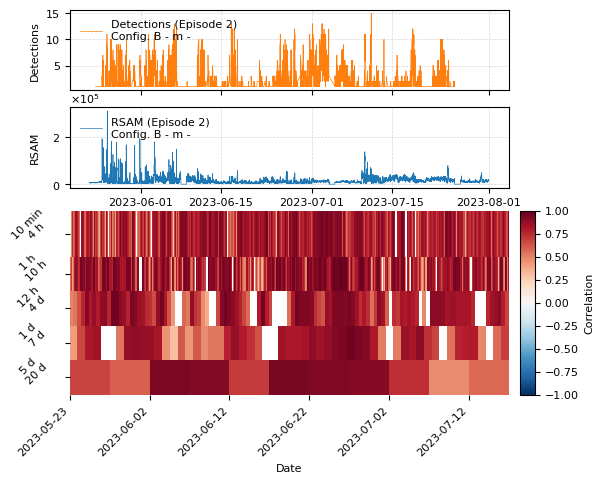

In [249]:

listofcorr = [ccf_Bm_10m_s2, ccf_Bm_1h_s2, ccf_Bm_12h_s2, ccf_Bm_1d_s2, ccf_Bm_5d_s2]
listoflabels = ['10 min \n 4 h ', '1 h\n10 h', '12 h\n 4 d', '1 d\n 7 d', '5 d\n20 d']

# --- Set up a GridSpec with extra column for colorbar ---
fig = plt.figure(figsize=(6, 5))  # widen slightly to fit colorbar
gs = gridspec.GridSpec(9, 2, width_ratios=[30, 1], height_ratios=[.7, .15, .7, .2, 0.4, .3, .3, .3, .3], hspace=0.0, wspace=0.05)

# --- Panel: Detections ---
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(cata_bbd_10m_s2.index, cata_bbd_10m_s2.values, label='Detections (Episode 2)\nConfig. B - m -', color='C1', linewidth=.5)
ax0.set_ylabel('Detections', fontsize=fontsizelegend)
ax0.tick_params(axis='x', labelbottom=False)
ax0.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax0.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax0.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panel: RSAM ---
ax1 = fig.add_subplot(gs[2, 0], sharex=ax0)
ax1.plot(rsam11_10m_s2.index, rsam11_10m_s2.values, label='RSAM (Episode 2)\nConfig. B - m -', color='C0', linewidth=.5)
ax1.set_ylabel('RSAM', fontsize=fontsizelegend)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.tick_params(axis='x', labelbottom=True, labelsize=fontsizelegend)
# for label in ax1.get_xticklabels():
#     label.set_fontsize(8)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax1.yaxis.offsetText.set_fontsize(8)
ax1.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax1.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panels: Heatmaps ---
heat_axes = [fig.add_subplot(gs[i, 0]) for i in range(4, 9)]
heatmap_refs = []  # collect for colorbar reference

for i, (ax, corr, label) in enumerate(zip(heat_axes, listofcorr, listoflabels)):
    hm = sns.heatmap(
        corr[['max_corr']].T,
        ax=ax,
        xticklabels=20,
        cbar=False,
        cmap="RdBu_r",
        vmin=-1, vmax=1,
    )
    heatmap_refs.append(hm)
    ax.set_ylabel(label, fontsize=8, rotation=45)
    ax.tick_params(axis='x', labelbottom=(i == 4), rotation=45)
    ax.tick_params(axis='y', labelsize=8, labelleft=False)

# Format final x-axis
xticks = np.arange(0, len(listofcorr[-1]), step=2)
xticklabels = [listofcorr[-1].index[i].strftime("%Y-%m-%d") for i in xticks]
heat_axes[-1].set_xticks(xticks)
heat_axes[-1].set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=8)
heat_axes[-1].set_xlabel("Date", fontsize=fontsizelegend)

# --- Shared colorbar on the right of heatmaps ---
from mpl_toolkits.axes_grid1 import make_axes_locatable
cax = fig.add_subplot(gs[4:9, 1])  # span rows 4 to 8 in the second column
cbar = plt.colorbar(heatmap_refs[-1].collections[0], cax=cax)
cbar.set_label("Correlation", fontsize=8)
cbar.ax.tick_params(labelsize=8)

fig.align_ylabels()
plt.savefig(os.path.join(rootouts, 'thesis', 'results.corr.B.rsam.ep2.png'), dpi=300, bbox_inches='tight')
plt.show()


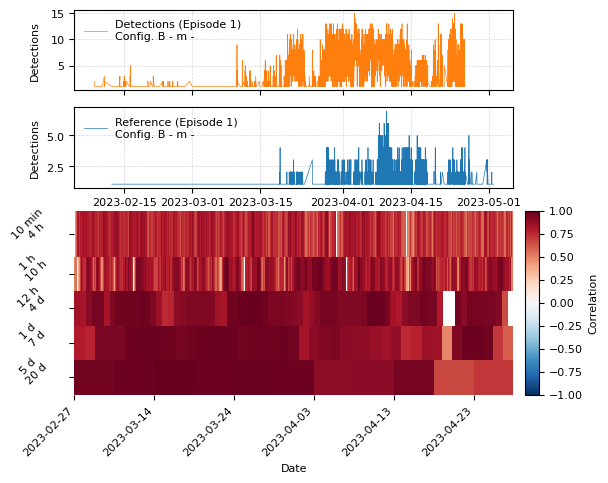

In [264]:


listofcorr = [ccf_Bm_ref_10m_s1, ccf_Bm_ref_1h_s1, ccf_Bm_ref_12h_s1, ccf_Bm_ref_1d_s1, ccf_Bm_ref_5d_s1]
listoflabels = ['10 min \n 4 h ', '1 h\n10 h', '12 h\n 4 d', '1 d\n 7 d', '5 d\n20 d']

# --- Set up a GridSpec with extra column for colorbar ---
fig = plt.figure(figsize=(6, 5))  # widen slightly to fit colorbar
gs = gridspec.GridSpec(9, 2, width_ratios=[30, 1], height_ratios=[.7, .15, .7, .2, 0.4, .3, .3, .3, .3], hspace=0.0, wspace=0.05)

# --- Panel: Detections ---
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(cata_bbd_10m_s1.index, cata_bbd_10m_s1.values, label='Detections (Episode 1)\nConfig. B - m -', color='C1', linewidth=.5)
ax0.set_ylabel('Detections', fontsize=fontsizelegend)
ax0.tick_params(axis='x', labelbottom=False)
ax0.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax0.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax0.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panel: Ref ---
ax1 = fig.add_subplot(gs[2, 0], sharex=ax0)
ax1.plot(ref_10m_s1.index, ref_10m_s1.values, label='Reference (Episode 1)\nConfig. B - m -', color='C0', linewidth=.5)
ax1.set_ylabel('Detections', fontsize=fontsizelegend)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.tick_params(axis='x', labelbottom=True, labelsize=fontsizelegend)
# for label in ax1.get_xticklabels():
#     label.set_fontsize(8)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax1.yaxis.offsetText.set_fontsize(8)
ax1.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax1.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panels: Heatmaps ---
heat_axes = [fig.add_subplot(gs[i, 0]) for i in range(4, 9)]
heatmap_refs = []  # collect for colorbar reference

for i, (ax, corr, label) in enumerate(zip(heat_axes, listofcorr, listoflabels)):
    hm = sns.heatmap(
        corr[['max_corr']].T,
        ax=ax,
        xticklabels=20,
        cbar=False,
        cmap="RdBu_r",
        vmin=-1, vmax=1,
    )
    heatmap_refs.append(hm)
    ax.set_ylabel(label, fontsize=8, rotation=45)
    ax.tick_params(axis='x', labelbottom=(i == 4), rotation=45)
    ax.tick_params(axis='y', labelsize=8, labelleft=False)

# Format final x-axis
xticks = np.arange(0, len(listofcorr[-1]), step=2)
xticklabels = [listofcorr[-1].index[i].strftime("%Y-%m-%d") for i in xticks]
heat_axes[-1].set_xticks(xticks)
heat_axes[-1].set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=8)
heat_axes[-1].set_xlabel("Date", fontsize=fontsizelegend)

# --- Shared colorbar on the right of heatmaps ---
from mpl_toolkits.axes_grid1 import make_axes_locatable
cax = fig.add_subplot(gs[4:9, 1])  # span rows 4 to 8 in the second column
cbar = plt.colorbar(heatmap_refs[-1].collections[0], cax=cax)
cbar.set_label("Correlation", fontsize=8)
cbar.ax.tick_params(labelsize=8)

fig.align_ylabels()
plt.savefig(os.path.join(rootouts, 'thesis', 'results.corr.B.ref.ep1.png'), dpi=300, bbox_inches='tight')
plt.show()


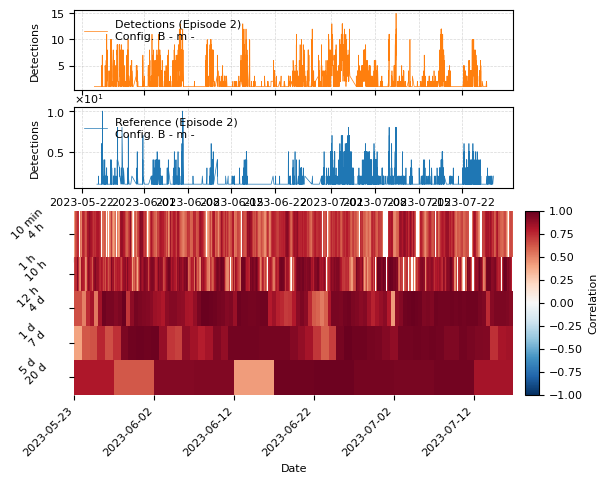

In [265]:

listofcorr = [ccf_Bm_ref_10m_s2, ccf_Bm_ref_1h_s2, ccf_Bm_ref_12h_s2, ccf_Bm_ref_1d_s2, ccf_Bm_ref_5d_s2]
listoflabels = ['10 min \n 4 h ', '1 h\n10 h', '12 h\n 4 d', '1 d\n 7 d', '5 d\n20 d']

# --- Set up a GridSpec with extra column for colorbar ---
fig = plt.figure(figsize=(6, 5))  # widen slightly to fit colorbar
gs = gridspec.GridSpec(9, 2, width_ratios=[30, 1], height_ratios=[.7, .15, .7, .2, 0.4, .3, .3, .3, .3], hspace=0.0, wspace=0.05)

# --- Panel: Detections ---
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(cata_bbd_10m_s2.index, cata_bbd_10m_s2.values, label='Detections (Episode 2)\nConfig. B - m -', color='C1', linewidth=.5)
ax0.set_ylabel('Detections', fontsize=fontsizelegend)
ax0.tick_params(axis='x', labelbottom=False)
ax0.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax0.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax0.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panel: Ref ---
ax1 = fig.add_subplot(gs[2, 0], sharex=ax0)
ax1.plot(ref_10m_s2.index, ref_10m_s2.values, label='Reference (Episode 2)\nConfig. B - m -', color='C0', linewidth=.5)
ax1.set_ylabel('Detections', fontsize=fontsizelegend)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.tick_params(axis='x', labelbottom=True, labelsize=fontsizelegend)
# for label in ax1.get_xticklabels():
#     label.set_fontsize(8)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax1.yaxis.offsetText.set_fontsize(8)
ax1.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax1.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panels: Heatmaps ---
heat_axes = [fig.add_subplot(gs[i, 0]) for i in range(4, 9)]
heatmap_refs = []  # collect for colorbar reference

for i, (ax, corr, label) in enumerate(zip(heat_axes, listofcorr, listoflabels)):
    hm = sns.heatmap(
        corr[['max_corr']].T,
        ax=ax,
        xticklabels=20,
        cbar=False,
        cmap="RdBu_r",
        vmin=-1, vmax=1,
    )
    heatmap_refs.append(hm)
    ax.set_ylabel(label, fontsize=8, rotation=45)
    ax.tick_params(axis='x', labelbottom=(i == 4), rotation=45)
    ax.tick_params(axis='y', labelsize=8, labelleft=False)

# Format final x-axis
xticks = np.arange(0, len(listofcorr[-1]), step=2)
xticklabels = [listofcorr[-1].index[i].strftime("%Y-%m-%d") for i in xticks]
heat_axes[-1].set_xticks(xticks)
heat_axes[-1].set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=8)
heat_axes[-1].set_xlabel("Date", fontsize=fontsizelegend)

# --- Shared colorbar on the right of heatmaps ---
from mpl_toolkits.axes_grid1 import make_axes_locatable
cax = fig.add_subplot(gs[4:9, 1])  # span rows 4 to 8 in the second column
cbar = plt.colorbar(heatmap_refs[-1].collections[0], cax=cax)
cbar.set_label("Correlation", fontsize=8)
cbar.ax.tick_params(labelsize=8)

fig.align_ylabels()
plt.savefig(os.path.join(rootouts, 'thesis', 'results.corr.B.ref.ep2.png'), dpi=300, bbox_inches='tight')
plt.show()


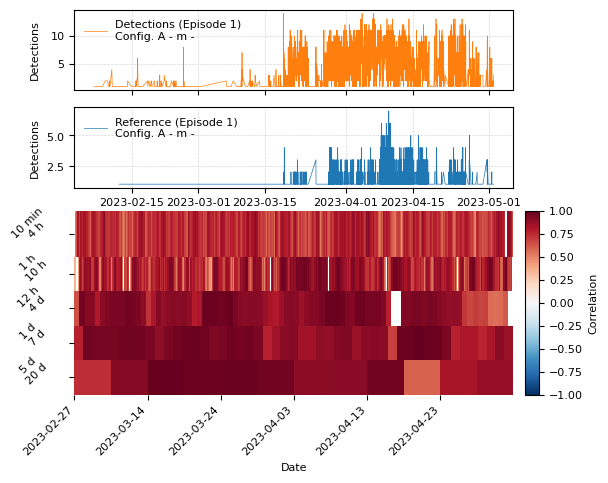

In [266]:

listofcorr = [ccf_ref_10m_s1, ccf_ref_1h_s1, ccf_ref_12h_s1, ccf_ref_1d_s1, ccf_ref_5d_s1]
listoflabels = ['10 min \n 4 h ', '1 h\n10 h', '12 h\n 4 d', '1 d\n 7 d', '5 d\n20 d']

# --- Set up a GridSpec with extra column for colorbar ---
fig = plt.figure(figsize=(6, 5))  # widen slightly to fit colorbar
gs = gridspec.GridSpec(9, 2, width_ratios=[30, 1], height_ratios=[.7, .15, .7, .2, 0.4, .3, .3, .3, .3], hspace=0.0, wspace=0.05)

# --- Panel: Detections ---
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(cata_10m_s1.index, cata_10m_s1.values, label='Detections (Episode 1)\nConfig. A - m -', color='C1', linewidth=.5)
ax0.set_ylabel('Detections', fontsize=fontsizelegend)
ax0.tick_params(axis='x', labelbottom=False)
ax0.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax0.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax0.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panel: Ref ---
ax1 = fig.add_subplot(gs[2, 0], sharex=ax0)
ax1.plot(ref_10m_s1.index, ref_10m_s1.values, label='Reference (Episode 1)\nConfig. A - m -', color='C0', linewidth=.5)
ax1.set_ylabel('Detections', fontsize=fontsizelegend)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.tick_params(axis='x', labelbottom=True, labelsize=fontsizelegend)
# for label in ax1.get_xticklabels():
#     label.set_fontsize(8)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax1.yaxis.offsetText.set_fontsize(8)
ax1.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax1.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panels: Heatmaps ---
heat_axes = [fig.add_subplot(gs[i, 0]) for i in range(4, 9)]
heatmap_refs = []  # collect for colorbar reference

for i, (ax, corr, label) in enumerate(zip(heat_axes, listofcorr, listoflabels)):
    hm = sns.heatmap(
        corr[['max_corr']].T,
        ax=ax,
        xticklabels=20,
        cbar=False,
        cmap="RdBu_r",
        vmin=-1, vmax=1,
    )
    heatmap_refs.append(hm)
    ax.set_ylabel(label, fontsize=8, rotation=45)
    ax.tick_params(axis='x', labelbottom=(i == 4), rotation=45)
    ax.tick_params(axis='y', labelsize=8, labelleft=False)

# Format final x-axis
xticks = np.arange(0, len(listofcorr[-1]), step=2)
xticklabels = [listofcorr[-1].index[i].strftime("%Y-%m-%d") for i in xticks]
heat_axes[-1].set_xticks(xticks)
heat_axes[-1].set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=8)
heat_axes[-1].set_xlabel("Date", fontsize=fontsizelegend)

# --- Shared colorbar on the right of heatmaps ---
from mpl_toolkits.axes_grid1 import make_axes_locatable
cax = fig.add_subplot(gs[4:9, 1])  # span rows 4 to 8 in the second column
cbar = plt.colorbar(heatmap_refs[-1].collections[0], cax=cax)
cbar.set_label("Correlation", fontsize=8)
cbar.ax.tick_params(labelsize=8)

fig.align_ylabels()
plt.savefig(os.path.join(rootouts, 'thesis', 'results.corr.A.ref.ep1.png'), dpi=300, bbox_inches='tight')
plt.show()


#### Plot simple RSAM vs Catalog

In [126]:
dfcata.values.max()

nan

In [136]:
ref_1d

Starttime
2023-02-12      2
2023-02-13      1
2023-02-24      1
2023-02-28      1
2023-03-09      1
             ... 
2023-07-22    193
2023-07-23    273
2023-07-24    183
2023-07-25     33
2023-07-26     75
Name: count, Length: 123, dtype: int64

C:\Users\Ludwig\AppData\Local\Temp\ipykernel_30652\792092409.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


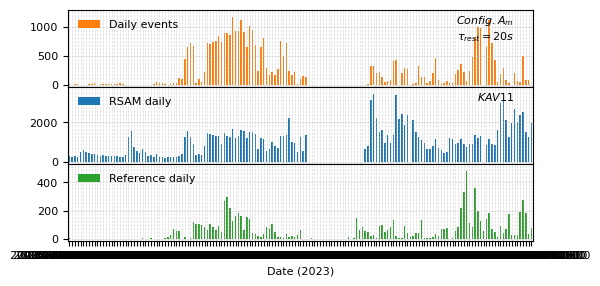

In [154]:
fig = plt.figure(figsize=(6, 3))  # widen slightly to fit colorbar
gs = gridspec.GridSpec(3, 1, hspace=0.0, wspace=0.05)
# --- Panel: Detections ---
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax2 = fig.add_subplot(gs[2], sharex=ax0)
axes = [ax0, ax1, ax2]

reference = pd.read_csv(os.path.join(rootouts, 'catalog_pl.txt'), sep='\t', parse_dates=['Starttime','Endtime'])
reference['Starttime'] = pd.to_datetime(reference['Starttime'])
ref             = reference[(reference['BAZ'] >= kav_angle[0]) & (reference['BAZ'] <= kav_angle[1])]
ref_1d = ref['Starttime'].dt.floor('1D').value_counts().sort_index()

dcata, tcata = cata_1d.values, cata_1d.index
drsam, trsam = rsam11_1d.values, rsam11_1d.index
dref,  tref  = ref_1d.values, ref_1d.index
dfcata = pd.DataFrame({'time': tcata, 'Daily events': dcata}).set_index('time').resample('1D').mean()
drsam = pd.DataFrame({'time': trsam, 'RSAM daily': drsam}).set_index('time').resample('1D').mean()
dfref = pd.DataFrame({'time': tref, 'Reference daily': dref}).set_index('time').resample('1D').mean()

dfcata.plot(ax=ax0, color='C1', linewidth=.5, label='Daily events', kind='bar')
drsam.plot(ax=ax1, color='C0', linewidth=.5, label='RSAM daily', kind='bar')
dfref.plot(ax=ax2, color='C2', linewidth=.5, label='Reference daily', kind='bar')

ax0.text(0.96, 0.95, '$Config. A_{m}$\n$\\tau_{rest}=20s$', transform=ax0.transAxes, fontsize=fontsizelegend, va='top', ha='right')
ax1.text(0.96, 0.95, '$KAV 11$', transform=ax1.transAxes, fontsize=fontsizelegend, va='top', ha='right')
[a.legend(fontsize=fontsizelegend, loc='upper left', frameon=False) for a in axes]

ax0.set_ylim(-0.03*dfcata.max().values, 1.1*dfcata.max().values)
ax1.set_ylim(-0.03*drsam.max().values, 1.1*drsam.max().values)
ax2.set_ylim(-0.03*dfref.max().values, 1.1*dfref.max().values)

[a.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5) for a in axes]
ax2.set_xlabel("Date (2023)", fontsize=fontsizelegend)
plt.tight_layout()
import matplotlib.dates as mdates

# [a.tick_params(axis='x', labelbottom=False) for a in axes]
# [a.set_xticks([]) for a in axes]  # Hide x-ticks for all but the last axis
# ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
[ax.tick_params(axis='both', labelsize=fontsizelegend, rotation=0) for ax in axes]

plt.savefig(os.path.join(rootouts, 'thesis', 'results.RSAM.ref.1D.png'), dpi=300, bbox_inches='tight')



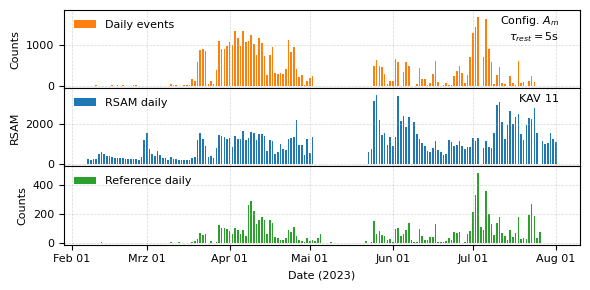

In [167]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import pandas as pd
import os

fontsizelegend = 8
sec = 5.0

# --- Setup figure and axes ---
fig = plt.figure(figsize=(6, 3))
gs = gridspec.GridSpec(3, 1, hspace=0.0)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax2 = fig.add_subplot(gs[2], sharex=ax0)
axes = [ax0, ax1, ax2]

# --- Load and prepare data ---
reference = pd.read_csv(os.path.join(rootouts, 'catalog_pl.txt'), sep='\t', parse_dates=['Starttime', 'Endtime'])
reference = reference[(reference['BAZ'] >= kav_angle[0]) & (reference['BAZ'] <= kav_angle[1])]
ref_1d = reference['Starttime'].dt.floor('1D').value_counts().sort_index()

# Reconstruct DataFrames from resampled values
c = pd.read_pickle(os.path.join(rootouts, 'cata_v11.3D_full_empiric',f'cata_v11.3D_full.empiric_{sec}s_slim.pkl'))
c = c['Eventtime(UTC)'].dt.floor('1D').value_counts().sort_index()
dfcata = pd.DataFrame({'time': c.index, 'Daily events': c.values}).set_index('time').resample('1D').mean()
# dfcata = pd.DataFrame({'time': cata_1d.index, 'Daily events': cata_1d.values}).set_index('time').resample('1D').mean()
drsam = pd.DataFrame({'time': rsam11_1d.index, 'RSAM daily': rsam11_1d.values}).set_index('time').resample('1D').mean()
dfref = pd.DataFrame({'time': ref_1d.index, 'Reference daily': ref_1d.values}).set_index('time').resample('1D').mean()

# --- Bar plots using matplotlib (with shared datetime x-axis) ---
width = .6
ax0.bar(dfcata.index, dfcata['Daily events'], width=width, color='C1', label='Daily events', linewidth=0.5)
ax1.bar(drsam.index, drsam['RSAM daily'], width=width, color='C0', label='RSAM daily', linewidth=0.5)
ax2.bar(dfref.index, dfref['Reference daily'], width=width, color='C2', label='Reference daily', linewidth=0.5)

# --- Annotations and axis labels ---
ax0.text(0.96, 0.95, 'Config. $A_{m}$\n$\\tau_{rest}=$'+f'{sec:.0f}'+'s',
         transform=ax0.transAxes, fontsize=fontsizelegend, ha='right', va='top')
# ax0.text(0.96, 0.95, '$\\mathrm{Config.\\ A_{m}}$\n$\\tau_{\\mathrm{rest}}=20\\,\\mathrm{s}$',
#          transform=ax0.transAxes, fontsize=fontsizelegend, ha='right', va='top')
ax1.text(0.96, 0.95, '$\\mathrm{KAV\\ 11}$', transform=ax1.transAxes,
         fontsize=fontsizelegend, ha='right', va='top')

for ax, df in zip(axes, [dfcata, drsam, dfref]):
    ax.set_ylim(-0.03 * df.max().values, 1.1 * df.max().values)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
    ax.tick_params(axis='both', labelsize=fontsizelegend)

[x.set_ylabel(label, fontsize=fontsizelegend) for x, label in zip(axes, ['Counts', 'RSAM', 'Counts'])]

# --- Shared x-axis setup ---
ax2.set_xlabel("Date (2023)", fontsize=fontsizelegend)
for ax in axes[:-1]:
    ax.tick_params(axis='x', labelbottom=False)

ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig(os.path.join(rootouts, 'thesis', f'results.RSAM.ref.1D.{sec}.png'), dpi=300, bbox_inches='tight')
plt.show()



C:\Users\Ludwig\AppData\Local\Temp\ipykernel_30652\3587573569.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


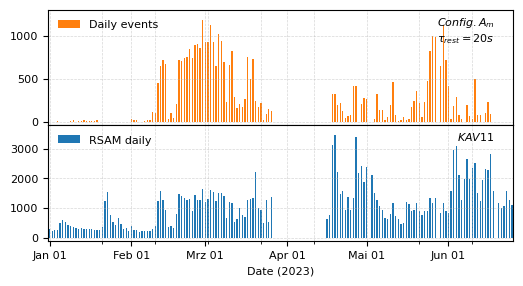

In [135]:
fig = plt.figure(figsize=(6, 3))  # widen slightly to fit colorbar
gs = gridspec.GridSpec(2, 1, hspace=0.0, wspace=0.05)
# --- Panel: Detections ---
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
axes = [ax0, ax1]

dcata, tcata = cata_1d.values, cata_1d.index
drsam, trsam = rsam11_1d.values, rsam11_1d.index
dfcata = pd.DataFrame({'time': tcata, 'Daily events': dcata}).set_index('time').resample('1D').mean()
# dfcata_Ac =
drsam = pd.DataFrame({'time': trsam, 'RSAM daily': drsam}).set_index('time').resample('1D').mean()

dfcata.plot(ax=ax0, color='C1', linewidth=.5, label='Daily events', kind='bar')
drsam.plot(ax=ax1, color='C0', linewidth=.5, label='RSAM daily', kind='bar')
# ax0.bar(dfcata.index, dfcata.values, color='C1', linewidth=.5, label='Daily events')

ax0.text(0.96, 0.95, '$Config. A_{m}$\n$\\tau_{rest}=20s$', transform=ax0.transAxes, fontsize=fontsizelegend, va='top', ha='right')
ax1.text(0.96, 0.95, '$KAV 11$', transform=ax1.transAxes, fontsize=fontsizelegend, va='top', ha='right')
[a.legend(fontsize=fontsizelegend, loc='upper left', frameon=False) for a in [ax0, ax1]]

ax0.set_ylim(-0.03*dfcata.max().values, 1.1*dfcata.max().values)
ax1.set_ylim(-0.03*drsam.max().values, 1.1*drsam.max().values)

[a.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5) for a in [ax0, ax1]]
ax1.set_xlabel("Date (2023)", fontsize=fontsizelegend)
plt.tight_layout()
import matplotlib.dates as mdates
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
[ax.tick_params(axis='both', labelsize=fontsizelegend, rotation=0) for ax in [ax0, ax1]]


plt.savefig(os.path.join(rootouts, 'thesis', 'results.RSAM.1D.png'), dpi=300, bbox_inches='tight')



### Correlation automatic for rsam and ref. for all configurations. 

In [32]:
def sliding_lagged_crosscorr(x, y, interval='1H', window_units=6, max_lag_units=2, step_units=1):
    """
    Compute lagged cross-correlation between x and y in a sliding window.
    
    Parameters
    ----------
    x, y : pandas Series
        Time series to compare. Must have datetime index and same frequency.
    interval : str
        Pandas-compatible interval string (e.g., '10min', '1H', '1D', '7D').
    window_units : int
        Window size in number of intervals (e.g., 6 x '1H' = 6 hours window).
    max_lag_units : int
        Max lag to consider in number of intervals.
    step_units : int
        Step size for sliding window in number of intervals.
    
    Returns
    -------
    DataFrame
        DataFrame with columns: 'max_corr', 'best_lag' and index as center time.
    """
    x = x.sort_index().resample(interval).mean()
    y = y.sort_index().resample(interval).mean()
    
    # Drop NaNs
    df = pd.concat([x, y], axis=1, join='inner').dropna()
    x, y = df.iloc[:, 0], df.iloc[:, 1]

    window = window_units
    max_lag = max_lag_units
    step = step_units

    results = []
    lags = np.arange(-max_lag, max_lag + 1)

    for i in range(0, len(x) - window, step):
        x_win = x.iloc[i:i+window].values
        y_win = y.iloc[i:i+window].values
        
        x_win -= np.mean(x_win)
        y_win -= np.mean(y_win)
        
        ccf = correlate(x_win, y_win, mode='full')
        std_product = np.std(x_win) * np.std(y_win)
        if std_product == 0:
            results.append({
                'time': x.index[i + window // 2],
                'max_corr': np.nan,
                'best_lag': np.nan
            })
            continue
        ccf /= (std_product * len(x_win))


        lag_idx = np.argmax(ccf)
        best_lag = lag_idx - (len(x_win) - 1)

        if abs(best_lag) <= max_lag:
            results.append({
                'time': x.index[i + window // 2],
                'max_corr': ccf[lag_idx],
                'best_lag': best_lag
            })
        else:
            results.append({
                'time': x.index[i + window // 2],
                'max_corr': np.nan,
                'best_lag': np.nan
            })

    return pd.DataFrame(results).set_index('time')


In [ ]:
# seconds = [5.0, 10.0, 20.0]
# modes = ['rsam','ref']

# # prepare rsam and catalog for cross-correlation at sampling rate of 1H
# rsam11 = pd.read_pickle(os.path.join(rootouts,'rsam_KAV11.pkl'))
# rsam00 = pd.read_pickle(os.path.join(rootouts,'rsam_KAV00.pkl'))
# # rsam.append(Trace(data=rsam11))
# rsam11['timedt'] = pd.to_datetime(rsam11['time'])
# rsam00['timedt'] = pd.to_datetime(rsam00['time'])

# rsam11_10m = rsam11.set_index('timedt')['rsam'].resample('10min').sum().dropna()
# rsam00_10m = rsam00.set_index('timedt')['rsam'].resample('10min').sum().dropna()
# rsam11_10m_df = pd.DataFrame({'timedt': rsam11_10m.index, 'rsam': rsam11_10m.values})
# rsam00_10m_df = pd.DataFrame({'timedt': rsam00_10m.index, 'rsam': rsam00_10m.values})

# [rsam11_1h, rsam11_12h, rsam11_1d, rsam11_5d] = [rsam11_10m_df.set_index('timedt')['rsam'].resample(interval).mean().dropna() for interval in ['1H', '12H', '1D', '5D']]
# [rsam00_1h, rsam00_12h, rsam00_1d, rsam00_5d] = [rsam00_10m_df.set_index('timedt')['rsam'].resample(interval).mean().dropna() for interval in ['1H', '12H', '1D', '5D']]

# # Define the angle range for Kavachi
# reference = pd.read_csv(os.path.join(rootouts, 'catalog_pl.txt'), sep='\t', parse_dates=['Starttime','Endtime'])
# ref = reference[(reference['BAZ'] >= kav_angle[0]) & (reference['BAZ'] <= kav_angle[1])]

# [ref_10m, ref_1h, ref_12h, ref_1d, ref_5d] = [ref['Starttime'].dt.floor(interval).value_counts().sort_index() for interval in ['10min', '1H', '12H', '1D', '5D']]


# windows = [24, 10, 8, 7, 4]
# intervals = ['10min', '1H', '12H', '1D', '5D']

# for sec in seconds:
#     for conf in ['A', 'B']:
#         # Load respective data
#         if conf == 'A':
#             cata = pd.read_pickle(os.path.join(rootouts, 'cata_v11.3D_full_empiric', f'cata_v11.3D_full.empiric_{sec}s_slim.pkl'))
#         else:
#             cata = pd.read_pickle(os.path.join(rootouts, 'cata_v11.bbd_full_empiric', f'cata_v11.bbd_full.empiric_{sec}s_slim.pkl'))

#         cata['timedt'] = pd.to_datetime(cata['Eventtime(UTC)'])

#         [cata_10m, cata_1h, cata_12h, cata_1d, cata_5d] = [cata['Eventtime(UTC)'].dt.floor(interval).value_counts().sort_index() for interval in ['10min', '1H', '12H', '1D', '5D']]

#         # Choose the data set 2 correlate with
#         for mode in modes:
#             if mode == 'rsam':
#                 d2corr_10m, d2corr_1h, d2corr_12h, d2corr_1d, d2corr_5d = rsam11_10m, rsam11_1h, rsam11_12h, rsam11_1d, rsam11_5d
#                 d2corrlabel = 'RSAM'
#             elif mode == 'ref':
#                 d2corr_10m, d2corr_1h, d2corr_12h, d2corr_1d, d2corr_5d = ref_10m, ref_1h, ref_12h, ref_1d, ref_5d
#                 d2corrlabel = 'Reference'
#             data2corr = [d2corr_10m, d2corr_1h, d2corr_12h, d2corr_1d, d2corr_5d]

#             # compute correlations
#             [ccf_10m, ccf_1h, ccf_12h, ccf_1d, ccf_5d] = [
#                 sliding_lagged_crosscorr(data2corr[i], x, interval=intervals[i], window_units=windows[i]) for i,x in enumerate([cata_10m, cata_1h, cata_12h, cata_1d, cata_5d])
#             ]
            
#             # listoflabels = ['10 min \n 4 h ', '1 h\n10 h', '12 h\n 4 d', '1 d\n 7 d', '5 d\n20 d']
#             listoflabels = ['[per 10 min]', '[per 1 h]', '[per 12 h]', '[per 1 d]', '[per 5 d]']
#             # Loop over seasons
#             for k, (s,e) in enumerate(seasons[:2]):
#                 modelabel = f'Detections Feb-Apr\n Config. ${conf}_m$' if k == 0 else f'Detections May-Jul\n Config. ${conf}_m$'

#                 # assign for each season
#                 inputs = [ccf_10m, ccf_1h, ccf_12h, ccf_1d, ccf_5d]
#                 inputs = [ccf[(ccf.index >= s) & (ccf.index <= e)] for ccf in inputs]
#                 listofcorr = [ccf[(ccf.index >= s) & (ccf.index <= e)] for ccf in inputs]
#                 detections = cata_10m[(cata_10m.index >= s) & (cata_10m.index <= e)]
#                 datareference = d2corr_10m[(d2corr_10m.index >= s) & (d2corr_10m.index <= e)]

#                 fig = plt.figure(figsize=(6, 5))  # widen slightly to fit colorbar
#                 gs = gridspec.GridSpec(9, 2, width_ratios=[30, 1], height_ratios=[.7, .15, .7, .2, 0.4, .3, .3, .3, .3], hspace=0.0, wspace=0.05)
                
#                 # --- Panel: Detections ---
#                 ax0 = fig.add_subplot(gs[0, 0])
#                 ax0.plot(detections.index, detections.values, label=modelabel, color='C1', linewidth=.5)
#                 ax0.set_ylabel('Detections', fontsize=fontsizelegend)

#                 # --- Panel: data2corr ---
#                 ax1 = fig.add_subplot(gs[2, 0], sharex=ax0)
#                 ax1.plot(datareference.index, datareference.values, label=d2corrlabel, color='C0', linewidth=.5)
#                 ax1.set_ylabel('Detections' if mode=='ref' else 'RSAM', fontsize=fontsizelegend)
#                 if not datareference.empty and not np.isnan(datareference.max()):
#                     ax1.set_ylim(top=.8*datareference.max())  # scale y-axis to factor*max of data2corr

#                 [ax.legend(fontsize=fontsizelegend, loc='upper left' if k==0 else 'upper right', frameon=False, alignment='right' if k==0 else 'left') for ax in [ax0, ax1]]
#                 [ax.tick_params(axis='both',labelsize=fontsizelegend) for ax in [ax0, ax1]]
#                 ax0.tick_params(axis='x', labelbottom=False)
#                 ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#                 ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#                 ax1.yaxis.offsetText.set_fontsize(8)
#                 [ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5) for ax in [ax0, ax1]]

#                 # --- Panels: Heatmaps ---
#                 heat_axes = [fig.add_subplot(gs[i, 0]) for i in range(4, 9)]
#                 # heat_axes = [fig.add_subplot(gs[i, 0], sharex=heat_axes[0] if i > 0 else None) for i in range(4, 9)]

#                 heatmap_refs = []  # collect for colorbar reference

#                 for i, (ax, corr, label) in enumerate(zip(heat_axes, listofcorr, listoflabels)):
#                     hm = sns.heatmap(
#                         corr[['max_corr']].T,
#                         ax=ax,
#                         xticklabels=20,
#                         cbar=False,
#                         cmap="RdBu_r",
#                         vmin=-1, vmax=1,
#                     )
#                     heatmap_refs.append(hm)
#                     ax.set_ylabel(label, fontsize=8, rotation=45)
#                     ax.tick_params(axis='x', labelbottom=(i == 4), rotation=45)
#                     ax.tick_params(axis='y', labelsize=8, labelleft=False)

#                 # Format final x-axis
#                 xticks = np.arange(0, len(listofcorr[-1]), step=2)
#                 xticklabels = [listofcorr[-1].index[i].strftime("%Y-%m-%d") for i in xticks]

#                 heat_axes[-1].set_xticks(xticks)
#                 heat_axes[-1].set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=8)
#                 heat_axes[-1].set_xlabel("Date", fontsize=fontsizelegend)

#                 # --- Shared colorbar on the right of heatmaps ---
#                 from mpl_toolkits.axes_grid1 import make_axes_locatable
#                 cax = fig.add_subplot(gs[4:9, 1])  # span rows 4 to 8 in the second column
#                 cbar = plt.colorbar(heatmap_refs[-1].collections[0], cax=cax)
#                 cbar.set_label("Correlation", fontsize=8)
#                 cbar.ax.tick_params(labelsize=8)

#                 fig.align_ylabels()
#                 # plt.savefig(os.path.join(rootouts, 'thesis', 'detectioncorrs',f'results.corr.{mode}.ep{k+1}.{sec}s.png'), dpi=300, bbox_inches='tight')
#                 plt.show()



In [39]:
seconds = [5.0, 10.0, 20.0]
modes = ['rsam','ref']

# prepare rsam and catalog for cross-correlation at sampling rate of 1H
rsam11 = pd.read_pickle(os.path.join(rootouts,'rsam_KAV11.pkl'))
rsam00 = pd.read_pickle(os.path.join(rootouts,'rsam_KAV00.pkl'))
# rsam.append(Trace(data=rsam11))
rsam11['timedt'] = pd.to_datetime(rsam11['time'])
rsam00['timedt'] = pd.to_datetime(rsam00['time'])

rsam11_10m = rsam11.set_index('timedt')['rsam'].resample('10min').sum().dropna()
rsam00_10m = rsam00.set_index('timedt')['rsam'].resample('10min').sum().dropna()
rsam11_10m_df = pd.DataFrame({'timedt': rsam11_10m.index, 'rsam': rsam11_10m.values})
rsam00_10m_df = pd.DataFrame({'timedt': rsam00_10m.index, 'rsam': rsam00_10m.values})

[rsam11_1h, rsam11_12h, rsam11_1d, rsam11_5d] = [rsam11_10m_df.set_index('timedt')['rsam'].resample(interval).mean().dropna() for interval in ['1H', '12H', '1D', '5D']]
[rsam00_1h, rsam00_12h, rsam00_1d, rsam00_5d] = [rsam00_10m_df.set_index('timedt')['rsam'].resample(interval).mean().dropna() for interval in ['1H', '12H', '1D', '5D']]

# Define the angle range for Kavachi
reference = pd.read_csv(os.path.join(rootouts, 'catalog_pl.txt'), sep='\t', parse_dates=['Starttime','Endtime'])
ref = reference[(reference['BAZ'] >= kav_angle[0]) & (reference['BAZ'] <= kav_angle[1])]

[ref_10m, ref_1h, ref_12h, ref_1d, ref_5d] = [ref['Starttime'].dt.floor(interval).value_counts().sort_index() for interval in ['10min', '1H', '12H', '1D', '5D']]


# windows     = [24, 10, 8, 7, 4]
windows     = [30, 30, 30, 20, 10]
intervals   = ['10min', '1H', '12H', '1D', '5D']

for sec in seconds:
    for conf in ['A', 'B']:
        # Load respective data
        if conf == 'A':
            cata = pd.read_pickle(os.path.join(rootouts, 'cata_v11.3D_full_empiric', f'cata_v11.3D_full.empiric_{sec}s_slim.pkl'))
        else:
            cata = pd.read_pickle(os.path.join(rootouts, 'cata_v11.bbd_full_empiric', f'cata_v11.bbd_full.empiric_{sec}s_slim.pkl'))

        cata['timedt'] = pd.to_datetime(cata['Eventtime(UTC)'])

        [cata_10m, cata_1h, cata_12h, cata_1d, cata_5d] = [cata['Eventtime(UTC)'].dt.floor(interval).value_counts().sort_index() for interval in ['10min', '1H', '12H', '1D', '5D']]

        # Choose the data set 2 correlate with
        for mode in modes:
            if mode == 'rsam':
                d2corr_10m, d2corr_1h, d2corr_12h, d2corr_1d, d2corr_5d = rsam11_10m, rsam11_1h, rsam11_12h, rsam11_1d, rsam11_5d
                d2corrlabel = 'RSAM'
            elif mode == 'ref':
                d2corr_10m, d2corr_1h, d2corr_12h, d2corr_1d, d2corr_5d = ref_10m, ref_1h, ref_12h, ref_1d, ref_5d
                d2corrlabel = 'Reference'
            data2corr = [d2corr_10m, d2corr_1h, d2corr_12h, d2corr_1d, d2corr_5d]

            # compute correlations
            [ccf_10m, ccf_1h, ccf_12h, ccf_1d, ccf_5d] = [
                sliding_lagged_crosscorr(data2corr[i], x, interval=intervals[i], 
                                         window_units=windows[i],
                                        # window_units=len(x)//10,
                                         max_lag_units=0,
                                         ) for i,x in enumerate([cata_10m, cata_1h, cata_12h, cata_1d, cata_5d])
            ]
            
            listoflabels = ['[10 min]', '[1 h]', '[12 h]', '[1 d]', '[5 d]']
            # Loop over seasons
            for k, (s,e) in enumerate(seasons[:2]):
                modelabel = f'Detections\n Config. ${conf}_m$' if k == 0 else f'Detections\n Config. ${conf}_m$'

                # assign for each season
                inputs          = [ccf_10m, ccf_1h, ccf_12h, ccf_1d, ccf_5d]
                inputs          = [ccf[(ccf.index >= s) & (ccf.index <= e)] for ccf in inputs]
                listofcorr      = [ ccf[(ccf.index >= s) & (ccf.index <= e)] for ccf in inputs]
                detections      = cata_1h[(cata_1h.index >= s) & (cata_1h.index <= e)]
                datareference   = d2corr_1h[(d2corr_1h.index >= s) & (d2corr_1h.index <= e)]

                # Set up the figure with GridSpec
                fig = plt.figure(figsize=(6, 5))  # widen slightly to fit colorbar
                gs  = gridspec.GridSpec(9, 2, width_ratios=[30, 1], height_ratios=[.7, .15, .7, .2, 0.3, .3, .3, .3, .3], hspace=0., wspace=0.05)
                
                # --- Panel: Detections ---
                ax0 = fig.add_subplot(gs[0, 0])
                ax0.plot(detections.index, detections.values, label=modelabel, color='C1', linewidth=.5)
                ax0.set_ylabel('Detections', fontsize=fontsizelegend)

                # --- Panel: data2corr ---
                ax1 = fig.add_subplot(gs[2, 0], sharex=ax0)
                ax1.plot(datareference.index, datareference.values, label=d2corrlabel, color='C0', linewidth=.5)
                
                ax1.set_ylabel('Detections' if mode=='ref' else 'RSAM', fontsize=fontsizelegend)
                if not datareference.empty and not np.isnan(datareference.max()):
                    ax1.set_ylim(top=.8*datareference.max())  # scale y-axis to factor*max of data2corr

                [ax.legend(fontsize=fontsizelegend, loc='upper left' if k==0 else 'upper right', frameon=False, alignment='right' if k==0 else 'left') for ax in [ax0, ax1]]
                [ax.tick_params(axis='both',labelsize=fontsizelegend) for ax in [ax0, ax1]]
                ax0.tick_params(axis='x', labelbottom=False)
                ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
                ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
                ax1.yaxis.offsetText.set_fontsize(8)
                [ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5) for ax in [ax0, ax1]]

                # --- Panels: Heatmaps ---
                heat_axes       = [fig.add_subplot(gs[i, 0], sharex=ax0) for i in range(4, 9)]
                heatmap_refs    = []  # collect for colorbar reference

                import matplotlib.colors as mcolors

                for i, (ax, corr, label) in enumerate(zip(heat_axes, listofcorr, listoflabels)):
                    data = corr['max_corr'].values  # shape (N,)
                    times = mdates.date2num(corr.index)  # shape (N,)
                    # For pcolormesh with shading='flat', X must be (N+1,), Y must be (2,), C must be (1, N)
                    # Extend times by one step at the end
                    if len(times) > 1:
                        dt = times[1] - times[0]
                    else:
                        dt = 1
                    times_edges = np.append(times, times[-1] + dt)
                    data_2d = data[np.newaxis, :]  # shape (1, N)
                    mesh = ax.pcolormesh(
                        times_edges,
                        [0, 1],
                        data_2d,
                        cmap='viridis',
                        # cmap="RdBu_r",
                        vmin=0,
                        vmax=1,
                        shading='flat'
                    )
                    yticks = [0.5]
                    yticklabels = [f'{label}']
                    ax.set_yticks(yticks)
                    ax.set_yticklabels(yticklabels, fontsize=fontsizelegend)
                    # ax.set_ylabel(label, fontsize=fontsizelegend) #, rotation=45, labelpad=12)
                    ax.tick_params(axis='x', labelbottom=(i == len(heat_axes)-1), rotation=45, labelsize=8)
                    if i != len(heat_axes) - 1:
                        ax.tick_params(axis='x', bottom=False, labelbottom=False)
                    else:
                        ax.set_xlabel("Date", fontsize=fontsizelegend)
                        if k==0:
                            ticks= pd.to_datetime(['2023-02-15', '2023-03-01', '2023-03-15', '2023-04-01', '2023-04-15', '2023-05-01'])
                        elif k==1:
                            ticks= pd.to_datetime(['2023-05-15', '2023-06-01', '2023-06-15', '2023-07-01'])
                        else:
                            ticks = pd.date_range(start=corr.index[0], end=corr.index[-1], freq='M')
                        ax.set_xticks(mdates.date2num(ticks))
                        ax.set_xticklabels([dt.strftime('%b %d') for dt in ticks], rotation=45, ha='right', fontsize=8)
                
                    ax.set_xlim(times[0], times[-1])
                    if i == 0:
                        cbar_ref = mesh

                # Super ylabel for heatmaps
                superlabel= fig.text(
                    0.01,                       # x-position in figure coords (left side)
                    0.3,                        # y-position centered vertically
                    "Samplings", # your super ylabel
                    va='center',
                    ha='center',
                    rotation='vertical',
                    fontsize=fontsizelegend,
                )
                # Draw the figure first so positions are updated
                fig.canvas.draw()

                # Extract y-label positions (in figure coordinates)
                ypos_ax0 = ax0.yaxis.label.get_position()[1]
                ypos_ax1 = ax1.yaxis.label.get_position()[1]
                # Transform from axes to figure coordinates
                transform_ax0 = ax0.transAxes + fig.transFigure.inverted()
                transform_ax1 = ax1.transAxes + fig.transFigure.inverted()

                fig_ypos_ax0 = transform_ax0.transform((0, ypos_ax0))[1]
                fig_ypos_ax1 = transform_ax1.transform((0, ypos_ax1))[1]

                [a.set_ylabel('') for a in [ax0, ax1]]
                fig.text(0.01, fig_ypos_ax0, 'Detections',                              va='center', ha='center', rotation='vertical', fontsize=fontsizelegend)
                fig.text(0.01, fig_ypos_ax1, 'Detections' if mode=='ref' else 'RSAM',   va='center', ha='center', rotation='vertical', fontsize=fontsizelegend)   


                # --- Shared colorbar on the right of heatmaps ---
                cax = fig.add_subplot(gs[4:9, 1])
                cbar = fig.colorbar(cbar_ref, cax=cax)
                cbar.set_label("Correlation", fontsize=fontsizelegend)
                cbar.ax.tick_params(labelsize=fontsizelegend)

                plt.savefig(os.path.join(rootouts, 'thesis', 'detectioncorrs',f'results4.corr.{mode}.ep{k+1}.{sec}s.png'), dpi=300, bbox_inches='tight')
                plt.close() # plt.show()



In [ ]:
# xlims
# len(listofcorr[0])
listofcorr[]

2135

In [73]:
# for p in range(len(listofcorr)):
#     # p = 0
#     print(f'min: {listofcorr[p].index.min()} - max: {listofcorr[p].index.max()}')

# listofcorr[0].index

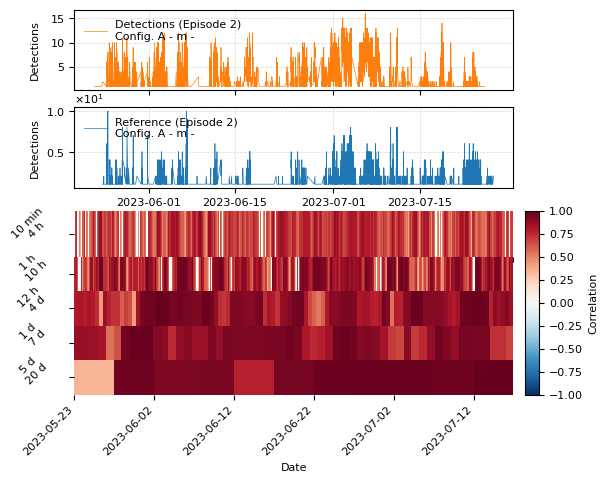

In [ ]:
listofcorr = [ccf_ref_10m_s1, ccf_ref_1h_s1, ccf_ref_12h_s1, ccf_ref_1d_s1, ccf_ref_5d_s1]
listoflabels = ['10 min \n 4 h ', '1 h\n10 h', '12 h\n 4 d', '1 d\n 7 d', '5 d\n20 d']

# --- Set up a GridSpec with extra column for colorbar ---
fig = plt.figure(figsize=(6, 5))  # widen slightly to fit colorbar
gs = gridspec.GridSpec(9, 2, width_ratios=[30, 1], height_ratios=[.7, .15, .7, .2, 0.4, .3, .3, .3, .3], hspace=0.0, wspace=0.05)

# --- Panel: Detections ---
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(cata_10m_s1.index, cata_10m_s1.values, label='Detections (Episode 1)\nConfig. A - m -', color='C1', linewidth=.5)
ax0.set_ylabel('Detections', fontsize=fontsizelegend)
ax0.tick_params(axis='x', labelbottom=False)
ax0.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax0.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax0.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panel: Ref ---
ax1 = fig.add_subplot(gs[2, 0], sharex=ax0)
ax1.plot(ref_10m_s1.index, ref_10m_s1.values, label='Reference (Episode 1)\nConfig. A - m -', color='C0', linewidth=.5)
ax1.set_ylabel('Detections', fontsize=fontsizelegend)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.tick_params(axis='x', labelbottom=True, labelsize=fontsizelegend)
# for label in ax1.get_xticklabels():
#     label.set_fontsize(8)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax1.yaxis.offsetText.set_fontsize(8)
ax1.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax1.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panels: Heatmaps ---
heat_axes = [fig.add_subplot(gs[i, 0]) for i in range(4, 9)]
heatmap_refs = []  # collect for colorbar reference

for i, (ax, corr, label) in enumerate(zip(heat_axes, listofcorr, listoflabels)):
    hm = sns.heatmap(
        corr[['max_corr']].T,
        ax=ax,
        xticklabels=20,
        cbar=False,
        cmap="RdBu_r",
        vmin=-1, vmax=1,
    )
    heatmap_refs.append(hm)
    ax.set_ylabel(label, fontsize=8, rotation=45)
    ax.tick_params(axis='x', labelbottom=(i == 4), rotation=45)
    ax.tick_params(axis='y', labelsize=8, labelleft=False)

# Format final x-axis
xticks = np.arange(0, len(listofcorr[-1]), step=2)
xticklabels = [listofcorr[-1].index[i].strftime("%Y-%m-%d") for i in xticks]
heat_axes[-1].set_xticks(xticks)
heat_axes[-1].set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=8)
heat_axes[-1].set_xlabel("Date", fontsize=fontsizelegend)

# --- Shared colorbar on the right of heatmaps ---
from mpl_toolkits.axes_grid1 import make_axes_locatable
cax = fig.add_subplot(gs[4:9, 1])  # span rows 4 to 8 in the second column
cbar = plt.colorbar(heatmap_refs[-1].collections[0], cax=cax)
cbar.set_label("Correlation", fontsize=8)
cbar.ax.tick_params(labelsize=8)

fig.align_ylabels()
plt.savefig(os.path.join(rootouts, 'thesis', 'results.corr.A.ref.ep1.png'), dpi=300, bbox_inches='tight')
plt.show()

listofcorr = [ccf_ref_10m_s2, ccf_ref_1h_s2, ccf_ref_12h_s2, ccf_ref_1d_s2, ccf_ref_5d_s2]
listoflabels = ['10 min \n 4 h ', '1 h\n10 h', '12 h\n 4 d', '1 d\n 7 d', '5 d\n20 d']

# --- Set up a GridSpec with extra column for colorbar ---
fig = plt.figure(figsize=(6, 5))  # widen slightly to fit colorbar
gs = gridspec.GridSpec(9, 2, width_ratios=[30, 1], height_ratios=[.7, .15, .7, .2, 0.4, .3, .3, .3, .3], hspace=0.0, wspace=0.05)

# --- Panel: Detections ---
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(cata_10m_s2.index, cata_10m_s2.values, label='Detections (Episode 2)\nConfig. A - m -', color='C1', linewidth=.5)
ax0.set_ylabel('Detections', fontsize=fontsizelegend)
ax0.tick_params(axis='x', labelbottom=False)
ax0.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax0.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax0.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panel: Ref ---
ax1 = fig.add_subplot(gs[2, 0], sharex=ax0)
ax1.plot(ref_10m_s2.index, ref_10m_s2.values, label='Reference (Episode 2)\nConfig. A - m -', color='C0', linewidth=.5)
ax1.set_ylabel('Detections', fontsize=fontsizelegend)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.tick_params(axis='x', labelbottom=True, labelsize=fontsizelegend)
# for label in ax1.get_xticklabels():
#     label.set_fontsize(8)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax1.yaxis.offsetText.set_fontsize(8)
ax1.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax1.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panels: Heatmaps ---
heat_axes = [fig.add_subplot(gs[i, 0]) for i in range(4, 9)]
heatmap_refs = []  # collect for colorbar reference

for i, (ax, corr, label) in enumerate(zip(heat_axes, listofcorr, listoflabels)):
    hm = sns.heatmap(
        corr[['max_corr']].T,
        ax=ax,
        xticklabels=20,
        cbar=False,
        cmap="RdBu_r",
        vmin=-1, vmax=1,
    )
    heatmap_refs.append(hm)
    ax.set_ylabel(label, fontsize=8, rotation=45)
    ax.tick_params(axis='x', labelbottom=(i == 4), rotation=45)
    ax.tick_params(axis='y', labelsize=8, labelleft=False)

# Format final x-axis
xticks = np.arange(0, len(listofcorr[-1]), step=2)
xticklabels = [listofcorr[-1].index[i].strftime("%Y-%m-%d") for i in xticks]
heat_axes[-1].set_xticks(xticks)
heat_axes[-1].set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=8)
heat_axes[-1].set_xlabel("Date", fontsize=fontsizelegend)

# --- Shared colorbar on the right of heatmaps ---
from mpl_toolkits.axes_grid1 import make_axes_locatable
cax = fig.add_subplot(gs[4:9, 1])  # span rows 4 to 8 in the second column
cbar = plt.colorbar(heatmap_refs[-1].collections[0], cax=cax)
cbar.set_label("Correlation", fontsize=8)
cbar.ax.tick_params(labelsize=8)

fig.align_ylabels()
plt.savefig(os.path.join(rootouts, 'thesis', 'results.corr.A.ref.ep2.png'), dpi=300, bbox_inches='tight')
plt.show()


In [ ]:

listofcorr = [ccf_ref_10m_s2, ccf_ref_1h_s2, ccf_ref_12h_s2, ccf_ref_1d_s2, ccf_ref_5d_s2]
listoflabels = ['10 min \n 4 h ', '1 h\n10 h', '12 h\n 4 d', '1 d\n 7 d', '5 d\n20 d']

# --- Set up a GridSpec with extra column for colorbar ---
fig = plt.figure(figsize=(6, 5))  # widen slightly to fit colorbar
gs = gridspec.GridSpec(9, 2, width_ratios=[30, 1], height_ratios=[.7, .15, .7, .2, 0.4, .3, .3, .3, .3], hspace=0.0, wspace=0.05)

# --- Panel: Detections ---
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(cata_10m_s2.index, cata_10m_s2.values, label='Detections (Episode 2)\nConfig. A - m -', color='C1', linewidth=.5)
ax0.set_ylabel('Detections', fontsize=fontsizelegend)
ax0.tick_params(axis='x', labelbottom=False)
ax0.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax0.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax0.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panel: Ref ---
ax1 = fig.add_subplot(gs[2, 0], sharex=ax0)
ax1.plot(ref_10m_s2.index, ref_10m_s2.values, label='Reference (Episode 2)\nConfig. A - m -', color='C0', linewidth=.5)
ax1.set_ylabel('Detections', fontsize=fontsizelegend)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.tick_params(axis='x', labelbottom=True, labelsize=fontsizelegend)
# for label in ax1.get_xticklabels():
#     label.set_fontsize(8)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax1.yaxis.offsetText.set_fontsize(8)
ax1.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
ax1.tick_params(axis='y', labelsize=fontsizelegend)

# --- Panels: Heatmaps ---
heat_axes = [fig.add_subplot(gs[i, 0]) for i in range(4, 9)]
heatmap_refs = []  # collect for colorbar reference

for i, (ax, corr, label) in enumerate(zip(heat_axes, listofcorr, listoflabels)):
    hm = sns.heatmap(
        corr[['max_corr']].T,
        ax=ax,
        xticklabels=20,
        cbar=False,
        cmap="RdBu_r",
        vmin=-1, vmax=1,
    )
    heatmap_refs.append(hm)
    ax.set_ylabel(label, fontsize=8, rotation=45)
    ax.tick_params(axis='x', labelbottom=(i == 4), rotation=45)
    ax.tick_params(axis='y', labelsize=8, labelleft=False)

# Format final x-axis
xticks = np.arange(0, len(listofcorr[-1]), step=2)
xticklabels = [listofcorr[-1].index[i].strftime("%Y-%m-%d") for i in xticks]
heat_axes[-1].set_xticks(xticks)
heat_axes[-1].set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=8)
heat_axes[-1].set_xlabel("Date", fontsize=fontsizelegend)

# --- Shared colorbar on the right of heatmaps ---
from mpl_toolkits.axes_grid1 import make_axes_locatable
cax = fig.add_subplot(gs[4:9, 1])  # span rows 4 to 8 in the second column
cbar = plt.colorbar(heatmap_refs[-1].collections[0], cax=cax)
cbar.set_label("Correlation", fontsize=8)
cbar.ax.tick_params(labelsize=8)

fig.align_ylabels()
plt.savefig(os.path.join(rootouts, 'thesis', 'results.corr.A.ref.ep2.png'), dpi=300, bbox_inches='tight')
plt.show()


# Read and prepare magnitudes
### Read
- Read catalog files and assign properly
### Analyse
- Match with refereces and extract backazimuth
- Plot Magnitudes over time and below daily means of magnitude and shaded the standard deviation
- Plot matched events as scatter plot x:time, y:magnitude and color coded the backazimuth. Make sure to convert the backazimuth from -180:180 into 0 North to 360
- compute log N log M
- Plot distribution seasonwise and illustrate peaks, peakswidth, mean and std

In [6]:
from scipy.signal import find_peaks

# --- Read and prepare magnitudes ---

# 1. Read catalog files and assign properly
import matplotlib.pyplot as plt

# Define seconds for catalog analysis
seconds = 20.0 

# Paths to catalogs (update as needed)
dir = 'computed_mags'
catalog_paths = {
    "A_m": os.path.join(rootouts, dir, f"cata_v11.3D_full.empiric_{seconds}s_slim.mlv.pkl"),
    "A_c": os.path.join(rootouts, dir, f"cata_v11.3D_full_compute_{seconds}s_slim.mlv.pkl"),
    "B_m": os.path.join(rootouts, dir, f"cata_v11.bbd_full.empiric_{seconds}s_slim.mlv.pkl"),
   # # "B_c": os.path.join(rootouts, "cata_v11.bbd_full_compute", "cata_v11.bbd_full.compute_20.0s_slim.pkl"),
}
catamags = {k: pd.read_pickle(v) for k, v in catalog_paths.items()}
klabels  = ['Config. A\n- m -', 'Config. A\n- c -', 'Config. B\n- m -']  # Labels for the plots
configlabel = ['Config. $A_{m}$', 'Config. $A_{c}$', 'Config. $B_{m}$']
klabels  = {k: klabels[i] for i, (k,_) in enumerate(catamags.items())}
# Reference catalog
ref_catalog_path = os.path.join(rootouts, "catalog_pl.txt")
ref_catalog = pd.read_csv(ref_catalog_path, sep='\t', parse_dates=['Starttime','Endtime'])
# ref_catalog = ref_catalog[(ref_catalog['BAZ'] >= kav_angle[0]) & (ref_catalog['BAZ'] <= kav_angle[1])]

# 2. Match with references and extract backazimuth
def match_events(df, ref, tolerance=pd.Timedelta("5s")):
    df = df.copy()
    df['Eventtime(UTC)'] = pd.to_datetime(df['Eventtime(UTC)'])
    ref = ref.copy()
    ref['Eventtime(UTC)'] = pd.to_datetime(ref['Starttime'])
    matched = pd.merge_asof(df.sort_values('Eventtime(UTC)'), ref.sort_values('Eventtime(UTC)'),
                            left_on='Eventtime(UTC)', right_on='Eventtime(UTC)', direction='nearest', tolerance=tolerance)
    matched = matched.dropna(subset=['Starttime'])
    return matched

matched_events = {k: match_events(cat, ref_catalog) for k, cat in catamags.items()}


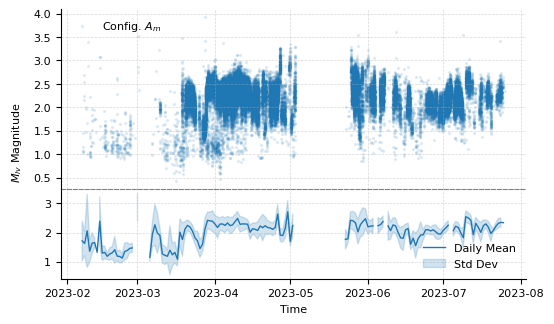

KeyboardInterrupt: 

In [169]:

# 3. Plot Magnitudes over time and daily means with std
for i, (k, cat) in enumerate(catamags.items()):
    daily = cat.set_index('Eventtime(UTC)').resample('1D')['mlv'].agg(['mean', 'std'])

    fig = plt.figure(figsize=(6, 3.5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.5], hspace=0.)
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    ax0.scatter(cat['Eventtime(UTC)'], cat['mlv'], s=2, alpha=0.1, label=configlabel[i])
    # ax0.set_ylabel(r"$M_{lv}$ Magnitude", fontsize=fontsizelegend)

    for j, (s, e) in enumerate(seasons):
        # d2p = daily[(pd.to_datetime(daily.index) >= pd.to_datetime(s)) & (pd.to_datetime(daily.index) <= pd.to_datetime(e))]
        d2p = daily[(daily.index >= s) & (daily.index <= e)]
        ax1.plot(d2p.index, d2p['mean'], label='Daily Mean' if j==0 else None, color='C0', linewidth=1)
        ax1.fill_between(d2p.index, d2p['mean'] - d2p['std'], 
                         d2p['mean'] + d2p['std'], color='C0', alpha=0.2, label='Std Dev' if j==0 else None)
        
    ax1.set_xlabel("Time", fontsize=fontsizelegend)
    [ax0.spines[pos].set_visible(False) for pos in ['top', 'right','bottom']]
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_linestyle('--')
    ax1.spines['top'].set_alpha(0.5)
    [a.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5) for a in [ax0, ax1]]
    [a.tick_params(axis='both', labelsize=fontsizelegend) for a in [ax0, ax1]]
    ax0.tick_params(axis='x', labelbottom=False, bottom=False)
    ax0.legend(fontsize=fontsizelegend, loc='upper left', frameon=False)
    ax1.legend(fontsize=fontsizelegend, loc='lower right', frameon=False)

    # common ylabel for both yaxes
    fig.text(0.04, 0.5, r"$M_{lv}$ Magnitude", va='center', rotation='vertical', fontsize=fontsizelegend)
    plt.savefig(os.path.join(rootouts, 'thesis', f'results.mags.{k}.{seconds}s.png'), dpi=300, bbox_inches='tight')
    plt.show()
    



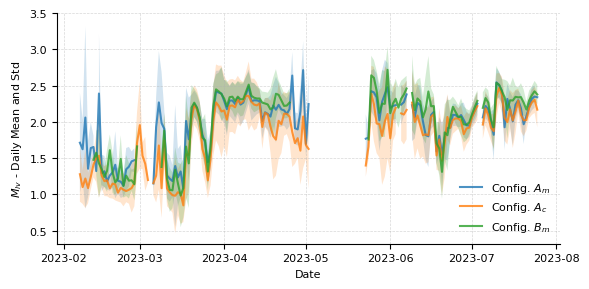

In [37]:

# Daily mean and std
fig = plt.figure(figsize=(6, 3))
ax = fig.gca()

for i,(k, cat) in enumerate(catamags.items()):
    daily = cat.set_index('Eventtime(UTC)').resample('1D')['mlv'].agg(['mean', 'std'])
    ax.plot(daily.index, daily['mean'], label=configlabel[i], alpha=.8)
    ax.fill_between(daily.index, daily['mean']-daily['std'], daily['mean']+daily['std'], alpha=0.2)
ax.set_xlabel("Date", fontsize=fontsizelegend)
ax.set_ylabel(r"$M_{lv}$ - Daily Mean and Std", fontsize=fontsizelegend)
ax.legend(frameon=False, fontsize=fontsizelegend, loc='lower right')
ax.tick_params(axis='both', labelsize=fontsizelegend)
# plt.title(r"Daily mean and std of $M_{lv}$ Magnitude")
plt.tight_layout()
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
[ax.spines[pos].set_visible(False) for pos in ['top', 'right']]
plt.savefig(os.path.join(rootouts, 'thesis', f"magnitudes_daily_mean_std_compare_{seconds}.png"), dpi=300, bbox_inches='tight')
plt.show()


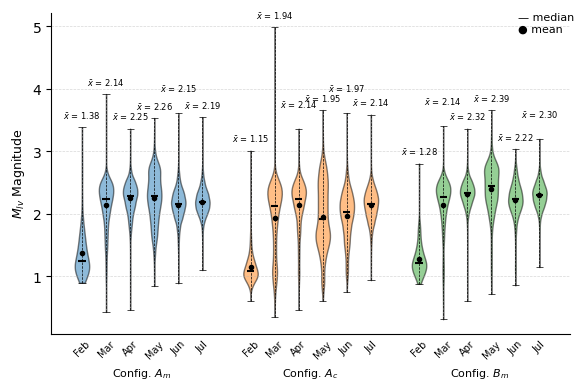

In [38]:
# Setup
box_data, box_labels, box_colors, positions = [], [], [], []

# Define months and their boundaries
months = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul']
month_starts = pd.date_range("2023-02-01", periods=6, freq='MS')
month_ends = pd.date_range("2023-02-28", periods=6, freq='M')
month_range = list(zip(month_starts, month_ends))

config_keys = ['A_m', 'A_c', 'B_m']
config_colors = {'A_m': 'tab:blue', 'A_c': 'tab:orange', 'B_m': 'tab:green'}

pos_counter = 1
for k in config_keys:
    cat = catamags[k]
    for i, (start, end) in enumerate(month_range):
        mask = (cat['Eventtime(UTC)'] >= start) & (cat['Eventtime(UTC)'] <= end)
        mags = cat.loc[mask, 'mlv'].dropna()
        box_data.append(mags)
        box_labels.append(months[i])
        box_colors.append(config_colors[k])
        positions.append(pos_counter)
        pos_counter += 1
    pos_counter += 1  # spacing between configurations

# --- Plotting ---
fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])

bp = ax.violinplot(box_data, positions=positions, widths=0.6, showmeans=False, showmedians=True)

# Style violin bodies
for i, pc in enumerate(bp['bodies']):
    pc.set_facecolor(box_colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

# Style extrema and medians
for key in ['cmins', 'cmaxes', 'cbars']:
    if key in bp:
        bp[key].set_color('black')
        bp[key].set_linestyle('--' if key == 'cbars' else '-')
        bp[key].set_linewidth(0.5)
if 'cmedians' in bp:
    bp['cmedians'].set_color('black')
    
for i, data in enumerate(box_data):
    mean_val = np.mean(data)
    max_val = np.max(data)

    # Plot the mean marker
    ax.plot(positions[i], mean_val, marker='o', color='black', markersize=3)

    # Annotate with x̄ = ...
    ax.annotate(
        f"$\\bar{{x}}$ = {mean_val:.2f}", # ⌀
        xy=(positions[i], max_val+ .2 if i in [4,8,10,13,17] else max_val),  # Adjust y position for better visibility
        xytext=(0, 5),
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=6,
        color='black'
    )


# Set x-axis
ax.set_xticks(positions)
ax.set_xticklabels(box_labels, rotation=45, fontsize=7)
ax.set_ylabel(r"$M_{lv}$ Magnitude", fontsize=9)

# Add configuration group labels
group_centers = [np.mean(positions[i*6:(i+1)*6]) for i in range(len(config_keys))]
for i, cfg in enumerate(config_keys):
    ax.annotate(configlabel[i], xy=(group_centers[i], -0.1), xycoords=('data', 'axes fraction'),
                ha='center', va='top', fontsize=8)

# Legend for median and mean
ax.annotate("— median\n● mean",
            # xy=(1.02, 1.02),
            xy=(.90, 1.),
            xycoords='axes fraction',
            ha='left', va='top',
            fontsize=8,
            bbox=dict(fc='none', ec='none'))

# Styling
[ax.spines[pos].set_visible(False) for pos in ['top', 'right']]
ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
ax.tick_params(axis='x', length=0)

plt.tight_layout()
plt.savefig(os.path.join(rootouts, 'thesis', f'results.mlv.boxplot.monthly.{seconds}s.png'), dpi=300, bbox_inches='tight')
plt.show()


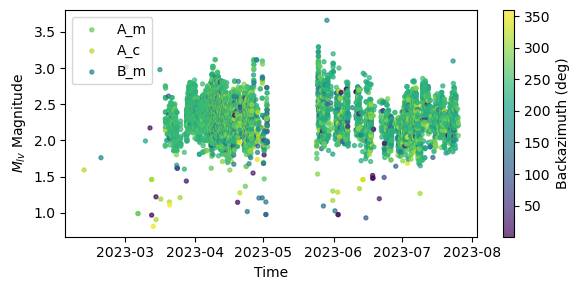

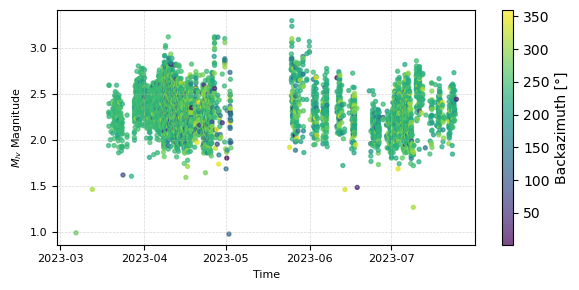

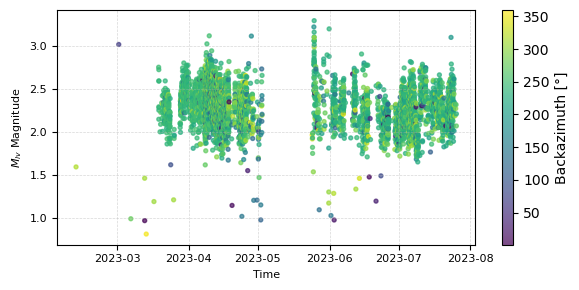

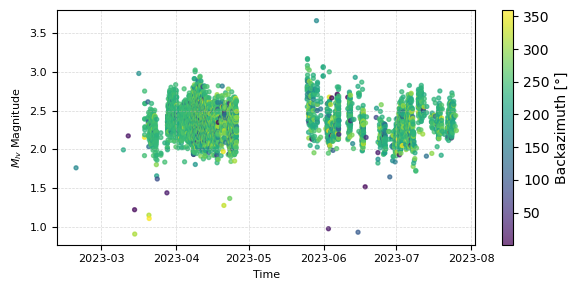

In [492]:

# 4. Plot matched events as scatter: x=time, y=magnitude, color=backazimuth (0-360)
plt.figure(figsize=(6, 3))
for k, df in matched_events.items():
    if 'BAZ' in df.columns:
        baz = df['BAZ'] % 360
        plt.scatter(df['Eventtime(UTC)'], df['mlv'], c=baz, cmap='viridis', s=8, alpha=0.7, label=k) # 'hsv'
plt.colorbar(label='Backazimuth (deg)')
plt.xlabel("Time")
plt.ylabel(r"$M_{lv}$ Magnitude")
plt.legend()
# plt.title(r"Matched events: $M_{lv}$ Magnitude vs Time (color=Backazimuth)")
plt.tight_layout()
plt.show()

for k, df in matched_events.items():
    if 'BAZ' in df.columns:
        baz = df['BAZ'] % 360
        # -- Create a scatter plot with backazimuth as color
        fig = plt.figure(figsize=(6, 3))
        ax = fig.gca()
        # axtwin = ax.twinx()  # Create a twin axis for better visibility
        # axtwin.set_ylabel('Backazimuth [°]', fontsize=fontsizelegend)
        # -- compute daily mean and std of mlv and backazimuth
        daily = df.set_index('Eventtime(UTC)').resample('1D').agg({'mlv': ['mean', 'std'], 'BAZ': ['mean', 'std']})
        daily.columns = ['mlv_mean', 'mlv_std', 'baz_mean', 'baz_std']

        scatter = ax.scatter(df['Eventtime(UTC)'], df['mlv'], c=baz, cmap='viridis', s=8, alpha=0.7)
        plt.colorbar(scatter, label='Backazimuth [°]')
        
        # -- Set labels and title
        ax.set_xlabel("Time", fontsize=fontsizelegend)
        ax.set_ylabel(r"$M_{lv}$ Magnitude", fontsize=fontsizelegend)
        # ax.set_title(f"Matched events: {klabels[k]} - $M_{lv}$ Magnitude vs Time (color=Backazimuth)")
        ax.tick_params(axis='both', labelsize=fontsizelegend)
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        plt.tight_layout()
        plt.savefig(os.path.join(rootouts, 'thesis', f'results.mlv.scatter.{k}.png'), dpi=300, bbox_inches='tight')
        plt.show()


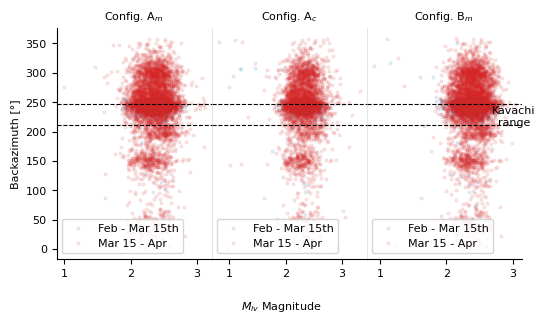

In [180]:

fig = plt.figure(figsize=(6, 3))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.0)
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
configs = ['A_m', 'A_c', 'B_m']
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange']
# seasonlabel = ['Feb - Apr', 'May - Jul']
# season_data = [seasons[0], seasons[1]]
seasonlabel = ['Feb - Mar 15th',
               'Mar 15 - Apr',
            #    'May - Jul'
            ]
season_data = [
    (pd.to_datetime('2023-02-01'), pd.to_datetime('2023-03-31')),
    (pd.to_datetime('2023-03-31'), pd.to_datetime('2023-04-30')),
    # (pd.to_datetime('2023-03-15'), pd.to_datetime('2023-04-30')),
    # (pd.to_datetime('2023-05-01'), pd.to_datetime('2023-07-31')),
]
kav_baz = np.array(kav_angle) % 360

for ax, cfg in zip(axes, configs):
    for i, season in enumerate(season_data):
        d = matched_events[cfg].loc[
            (matched_events[cfg]['Eventtime(UTC)'] >= season[0]) &
            (matched_events[cfg]['Eventtime(UTC)'] <= season[1])
        ]
        ax.plot(d['mlv'], d['BAZ'] % 360, 'o',
                markersize=2, alpha=0.1, color=colors[i], label=seasonlabel[i])

    # Horizontal lines for Kavachi backazimuth range
    for y in kav_baz:
        ax.axhline(y=y, color='k', linestyle='--', linewidth=0.8)

    # Axis formatting
    ax.tick_params(axis='both', labelsize=fontsizelegend)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=fontsizelegend, loc='lower left', frameon=True)

# First subplot gets y-axis and ylabel
axes[0].set_ylabel('Backazimuth [°]', fontsize=fontsizelegend)

# Other plots: hide y-ticks and spines
for ax in axes[1:]:
    ax.tick_params(axis='y', labelleft=False, left=False, labelsize=fontsizelegend)
    ax.spines['left'].set_alpha(0.1)

# Add configuration labels above each subplot
for ax, label in zip(axes, ['Config. A$_m$', 'Config. A$_c$', 'Config. B$_m$']):
    ax.set_title(label, fontsize=fontsizelegend, pad=6)

# Add overall bottom xlabel
fig.text(0.5, -0.05, r"$M_{lv}$ Magnitude", ha='center', va='center', fontsize=fontsizelegend)

# Annotation for Kavachi range
axes[-1].text(0.95, .57, 'Kavachi\nrange', fontsize=fontsizelegend, color='k',
              ha='center', va='bottom', transform=axes[-1].transAxes)

# plt.savefig(os.path.join(rootouts, 'thesis', f'results.mlv.scatter.baz.{seconds}s.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(rootouts, 'thesis', f'results.mlv.scatter.baz.ex.{seconds}s.png'), dpi=300, bbox_inches='tight')

plt.show()


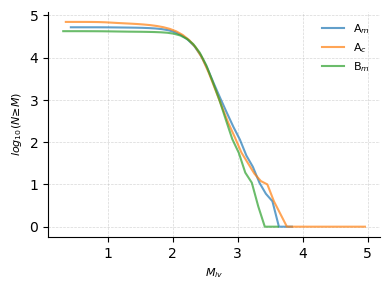

In [40]:

# 5. Compute log N - log M
plt.figure(figsize=(4, 3))
ax = plt.gca()
lognlogmlabels = ['A$_m$', 
                  'A$_c$', 
                  'B$_m$']
for i, (k, cat) in enumerate(catamags.items()):
    mags = cat['mlv'].dropna()
    bins = np.arange(mags.min(), mags.max(), 0.1)
    N = [np.sum(mags >= m) for m in bins]
    ax.plot(bins, np.log10(N), alpha=0.7, label=lognlogmlabels[i])
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax.set_xlabel(r"$M_{lv}$", fontsize=fontsizelegend)
ax.set_ylabel(r"$log_{10}(N≥M)$", fontsize=fontsizelegend)
ax.legend(fontsize=fontsizelegend, frameon=False)
# plt.title("log N - log M")
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(os.path.join(rootouts, 'thesis', f'results.logNlogM.{seconds}s.png'), dpi=300, bbox_inches='tight')
plt.show()


C:\Users\Ludwig\AppData\Local\Temp\ipykernel_30652\8802263.py:25: RuntimeWarning: divide by zero encountered in log10
  logN = np.log10(N)


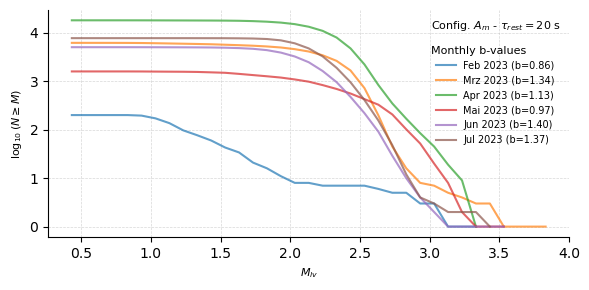

In [222]:
from matplotlib.dates import DateFormatter

# 5. Compute log N - log M, monthwise for the first catamags item only
# seconds = 20.0
first_key, first_cat = list(catamags.items())[0]
df = catamags[first_key]

# Step 2: Add a 'month' column for grouping
df['month'] = df['Eventtime(UTC)'].dt.to_period('M')

# Step 3: Prepare the plot
plt.figure(figsize=(6, 3))
ax = plt.gca()

# Step 4: Define fontsize and binning
fontsizelegend = 8
bins = np.arange(df['mlv'].min(), df['mlv'].max() + 0.1, 0.1)

# Step 5: Loop over months
for name, group in df.groupby('month'):
    mags = group['mlv'].dropna()
    if len(mags) < 10:
        continue  # Skip months with too few data
    N = [np.sum(mags >= m) for m in bins]
    logN = np.log10(N)
    
    # Fit linear regression to logN vs. M
    valid = np.isfinite(logN) & (np.array(N) > 0)
    x = bins[valid]
    y = logN[valid]
    slope, intercept = np.polyfit(x, y, 1)
    b_value = -slope
    
    # Plot
    ax.plot(x, y, label=f"{name.strftime('%b %Y')} (b={b_value:.2f})", alpha=0.7)


# Final plot adjustments
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax.set_xlabel(r"$M_{lv}$", fontsize=fontsizelegend)
ax.set_ylabel(r"$\log_{10}(N \geq M)$", fontsize=fontsizelegend)
ax.legend(fontsize=fontsizelegend - 1, frameon=False, title='Config. $A_m$ - $\\tau_{rest}=20$ s\n \nMonthly b-values', title_fontsize=fontsizelegend)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(os.path.join(rootouts, 'thesis', f'results.logNlogM.monthwise.{seconds}s.png'), dpi=300, bbox_inches='tight')
plt.show()


C:\Users\Ludwig\AppData\Local\Temp\ipykernel_25040\1650775269.py:46: RuntimeWarning: divide by zero encountered in log10
  logN = np.log10(N)


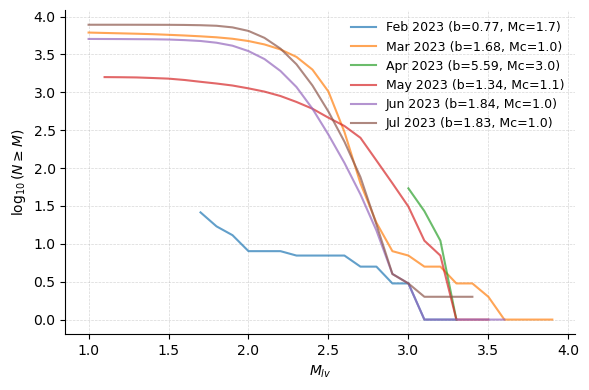

In [8]:
from scipy.stats import kstest
from scipy.optimize import minimize
from matplotlib.dates import DateFormatter

# 5. Compute log N - log M, monthwise for the first catamags item only
seconds = 20.0
first_key, first_cat = list(catamags.items())[0]
df = catamags[first_key]
df['month'] = df['Eventtime(UTC)'].dt.to_period('M')

# Magnitude of completeness estimator
def estimate_mc(magnitudes, bin_width=0.1):
    candidate_mcs = np.arange(1.0, 3.5, bin_width)
    best_mc = candidate_mcs[0]
    best_ks_stat = np.inf

    for mc in candidate_mcs:
        mags_above_mc = magnitudes[magnitudes >= mc]
        if len(mags_above_mc) < 20:
            continue

        b = (np.log10(np.e)) / (np.mean(mags_above_mc) - mc)
        ks_stat, _ = kstest(mags_above_mc, lambda x: np.exp(-b * np.log(10) * (x - mc)))

        if ks_stat < best_ks_stat:
            best_ks_stat = ks_stat
            best_mc = mc

    return best_mc

# Plotting and monthly b-value calculation
plt.figure(figsize=(6, 4))
ax = plt.gca()
fontsizelegend = 10
monthly_bvals = []

for name, group in df.groupby('month'):
    mags = group['mlv'].dropna()
    if len(mags) < 20:
        continue

    mc = estimate_mc(mags)
    mags_above_mc = mags[mags >= mc]
    bins = np.arange(mc, mags_above_mc.max() + 0.1, 0.1)
    N = [np.sum(mags_above_mc >= m) for m in bins]
    logN = np.log10(N)
    
    valid = np.isfinite(logN) & (np.array(N) > 0)
    x = bins[valid]
    y = logN[valid]
    slope, intercept = np.polyfit(x, y, 1)
    b_value = -slope
    monthly_bvals.append((name.strftime('%Y-%m'), b_value, mc))

    ax.plot(x, y, label=f"{name.strftime('%b %Y')} (b={b_value:.2f}, Mc={mc:.1f})", alpha=0.7)

ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax.set_xlabel(r"$M_{lv}$", fontsize=fontsizelegend)
ax.set_ylabel(r"$\log_{10}(N \geq M)$", fontsize=fontsizelegend)
ax.legend(fontsize=fontsizelegend - 1, frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [214]:
df_bvalue['time']

0     2023-02-06/2023-02-12
1     2023-02-13/2023-02-19
2     2023-02-20/2023-02-26
3     2023-03-06/2023-03-12
4     2023-03-13/2023-03-19
5     2023-03-20/2023-03-26
6     2023-03-27/2023-04-02
7     2023-04-03/2023-04-09
8     2023-04-10/2023-04-16
9     2023-04-17/2023-04-23
10    2023-04-24/2023-04-30
11    2023-05-01/2023-05-07
12    2023-05-22/2023-05-28
13    2023-05-29/2023-06-04
14    2023-06-05/2023-06-11
15    2023-06-12/2023-06-18
16    2023-06-19/2023-06-25
17    2023-06-26/2023-07-02
18    2023-07-03/2023-07-09
19    2023-07-10/2023-07-16
20    2023-07-17/2023-07-23
21    2023-07-24/2023-07-30
Name: time, dtype: period[W-SUN]

In [ ]:
cat = catamags['A_m']  # Use the first catalog for daily mean and std
daily = cat.set_index('Eventtime(UTC)').resample('1D')['mlv'].agg(['mean', 'std'])

df_b = df_bvalue.copy()
df_b['time'] = pd.to_datetime(df_b['time']

fig = plt.figure(figsize=(6, 3))
gs = gridspec.GridSpec(2, 1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)

ax0.plot(df_bvalue['time'], df_bvalue['b_value'])

   
for j, (s, e) in enumerate(seasons):
    # d2p = daily[(pd.to_datetime(daily.index) >= pd.to_datetime(s)) & (pd.to_datetime(daily.index) <= pd.to_datetime(e))]
    d2p = daily[(daily.index >= s) & (daily.index <= e)]
    ax1.plot(d2p.index, d2p['mean'], label='Daily Mean', color='C0', linewidth=1)
    ax1.fill_between(d2p.index, d2p['mean'] - d2p['std'], 
                        d2p['mean'] + d2p['std'], color='C0', alpha=0.2, label='Std Dev' )


TypeError: Passing PeriodDtype data is invalid. Use `data.to_timestamp()` instead

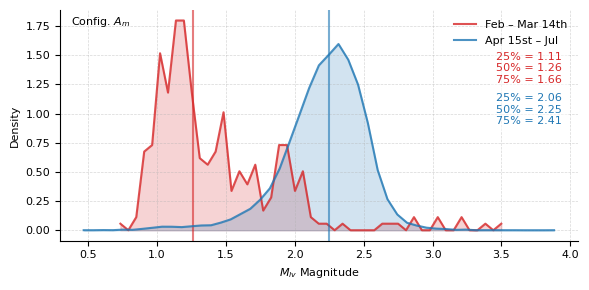

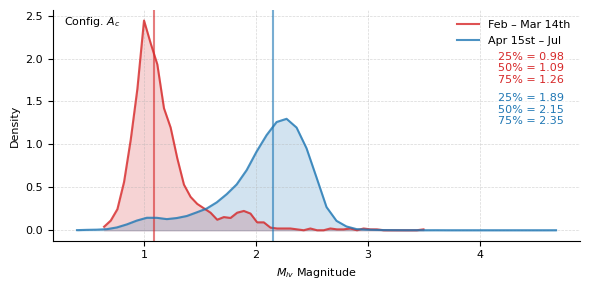

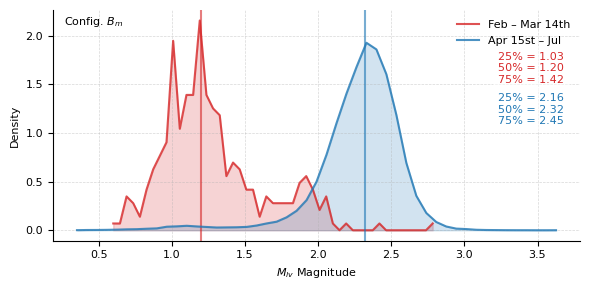

In [224]:
# seconds = 20.0
# --- Configuration ---
colors = ['tab:red', 'tab:blue']

season_labels = ['Feb – Mar 14th', 'Apr 15st – Jul']
# season_data = seasons[:2]
season_data = [(pd.to_datetime('2023-02-01'), pd.to_datetime('2023-03-14')),
               (pd.to_datetime('2023-03-15'), pd.to_datetime('2023-07-31'))]
nbins = 50#50

for i, (k, cat) in enumerate(catamags.items()):

    config_key = k
    config_label = configlabel[i]

    # --- Plot Setup ---
    fig = plt.figure(figsize=(6, 3))
    ax = plt.gca()

    for i, (start, end) in enumerate(season_data):
        mask = (cat['Eventtime(UTC)'] >= pd.to_datetime(start)) & (cat['Eventtime(UTC)'] <= pd.to_datetime(end))
        mags = cat.loc[mask, 'mlv'].dropna()
        if len(mags) == 0:
            continue

        # Histogram
        bins = np.linspace(mags.min(), mags.max(), nbins)
        counts, bin_edges = np.histogram(mags, bins=bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        ax.plot(bin_centers, counts, label=season_labels[i], color=colors[i], alpha=0.8)
        ax.fill_between(bin_centers, counts, alpha=0.2, color=colors[i])

        # Mean and Percentiles
        perc25, perc50, perc75 = np.percentile(mags, [25, 50, 75])
        ax.axvline(perc50, color=colors[i], linestyle='-', alpha=0.6) # label=f'median')
        # for val, style in zip([perc25, perc50, perc75], ['-.', '-', '-.']):
        #     ax.axvline(val, color=colors[i], linestyle=style, alpha=0.6)

        # Annotate percentiles legend
        ax.text(
            0.97, 0.82 - i * 0.18,  # move right and space vertically for 3 lines
            f"25% = {perc25:.2f}\n50% = {perc50:.2f}\n75% = {perc75:.2f}",
            transform=ax.transAxes,
            fontsize=fontsizelegend,
            color=colors[i],
            ha='right',
            va='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
        )

    ax.text(0.02, 0.98, config_label, transform=ax.transAxes, fontsize=fontsizelegend, ha='left', va='top')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
    # ax.set_title(f"$M_{{lv}}$ Magnitude Distribution – {config_key}", fontsize=10)
    ax.set_xlabel(r"$M_{lv}$ Magnitude", fontsize=fontsizelegend)
    ax.set_ylabel("Density", fontsize=fontsizelegend)
    ax.legend(fontsize=fontsizelegend, loc='upper right', frameon=False)
    ax.tick_params(axis='both', labelsize=fontsizelegend)
    [ax.spines[pos].set_visible(False) for pos in ['top', 'right']]
    plt.tight_layout()
    plt.savefig(os.path.join(rootouts, 'thesis', f'results.mlv.dist.{config_key}.{seconds}s.png'), dpi=300, bbox_inches='tight')
    plt.show()
